# M= 2^20

In [1]:
import os
from dotenv import load_dotenv

load_dotenv();

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns

from icl.analysis.utils import get_unique_run
from devinterp.mechinterp.hooks import hook

sns.set_style('whitegrid')

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_seed" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [4]:
run = get_unique_run(
    "../sweeps/small-sweep-2.yaml", 
    task_config={"num_tasks": 2**20, "num_layers": 2},
    optimizer_config={"lr": 0.01}
)

In [5]:
# Confirm that we've loaded in the most recent model
run.evaluator(run.model)

{'pretrain/mse': 1.722325325012207,
 'pretrain/delta_dmmse': tensor(0.1172, device='mps:0'),
 'pretrain/delta_ridge': tensor(0.1165, device='mps:0'),
 'pretrain/token/0': 3.999706268310547,
 'pretrain/token/1': 3.128201961517334,
 'pretrain/token/2': 2.1744866371154785,
 'pretrain/token/3': 1.539637804031372,
 'pretrain/token/4': 1.0379008054733276,
 'pretrain/token/5': 0.8370570540428162,
 'pretrain/token/6': 0.5883678793907166,
 'pretrain/token/7': 0.4732441306114197,
 'true/mse': 1.8321335315704346,
 'true/delta_dmmse': tensor(0.1222, device='mps:0'),
 'true/delta_ridge': tensor(0.1226, device='mps:0'),
 'true/token/0': 4.430878639221191,
 'true/token/1': 3.33992338180542,
 'true/token/2': 2.197641372680664,
 'true/token/3': 1.713287591934204,
 'true/token/4': 1.017869234085083,
 'true/token/5': 0.8117557168006897,
 'true/token/6': 0.6247320175170898,
 'true/token/7': 0.5209808349609375}

In [6]:
list(run.model.state_dict().keys())

['token_sequence_transformer.token_embedding.weight',
 'token_sequence_transformer.postn_embedding.weight',
 'token_sequence_transformer.blocks.0.attention.causal_mask',
 'token_sequence_transformer.blocks.0.attention.attention.weight',
 'token_sequence_transformer.blocks.0.compute.0.weight',
 'token_sequence_transformer.blocks.0.compute.0.bias',
 'token_sequence_transformer.blocks.0.compute.2.weight',
 'token_sequence_transformer.blocks.0.compute.2.bias',
 'token_sequence_transformer.blocks.0.layer_norms.0.weight',
 'token_sequence_transformer.blocks.0.layer_norms.0.bias',
 'token_sequence_transformer.blocks.0.layer_norms.1.weight',
 'token_sequence_transformer.blocks.0.layer_norms.1.bias',
 'token_sequence_transformer.blocks.1.attention.causal_mask',
 'token_sequence_transformer.blocks.1.attention.attention.weight',
 'token_sequence_transformer.blocks.1.compute.0.weight',
 'token_sequence_transformer.blocks.1.compute.0.bias',
 'token_sequence_transformer.blocks.1.compute.2.weight',
 

# Reverse Engineering

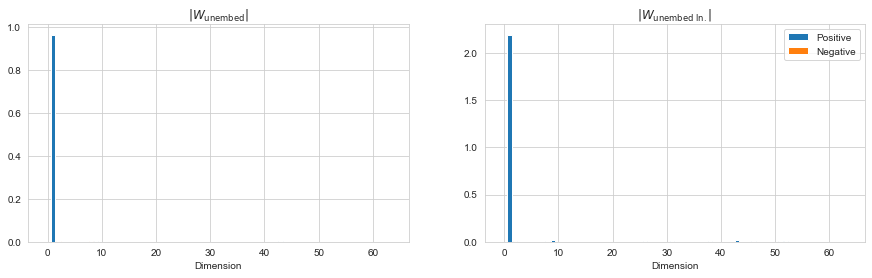

In [8]:
num_tasks = 2**20

# Last time we had luck looking at the unembed and layer norm. Let's start there.

unembed_weights = run.model.token_sequence_transformer.unembedding[1].weight[0, :]
unembed_ln = run.model.token_sequence_transformer.unembedding[0].weight

unembed_pos_weights = unembed_weights.clone()
unembed_pos_weights[unembed_weights < 0] = 0
unembed_neg_weights = unembed_weights.clone()
unembed_neg_weights[unembed_weights > 0] = 0
unembed_neg_weights = unembed_neg_weights.abs()

unembed_pos_ln = unembed_ln.clone()
unembed_pos_ln[unembed_ln < 0] = 0
unembed_neg_ln = unembed_ln.clone()
unembed_neg_ln[unembed_ln > 0] = 0
unembed_neg_ln = unembed_neg_ln.abs()


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4))

ax0.bar(range(len(unembed_weights)), unembed_pos_weights.detach().cpu().numpy(), label="Positive")
ax0.bar(range(len(unembed_weights)), unembed_neg_weights.detach().cpu().numpy(), label="Negative")
ax0.set_title("$|W_\mathrm{unembed}|$")
ax0.set_xlabel("Dimension")
# ax0.set_yscale("log")
# ax0.legend()

ax1.bar(range(len(unembed_ln)), unembed_pos_ln.detach().cpu().numpy(), label="Positive")
ax1.bar(range(len(unembed_ln)), unembed_neg_ln.detach().cpu().numpy(), label="Negative")
ax1.set_title("$|W_\mathrm{unembed\ ln.}|$")
ax1.set_xlabel("Dimension")
#ax1.set_yscale("log")
ax1.legend()

plt.show()


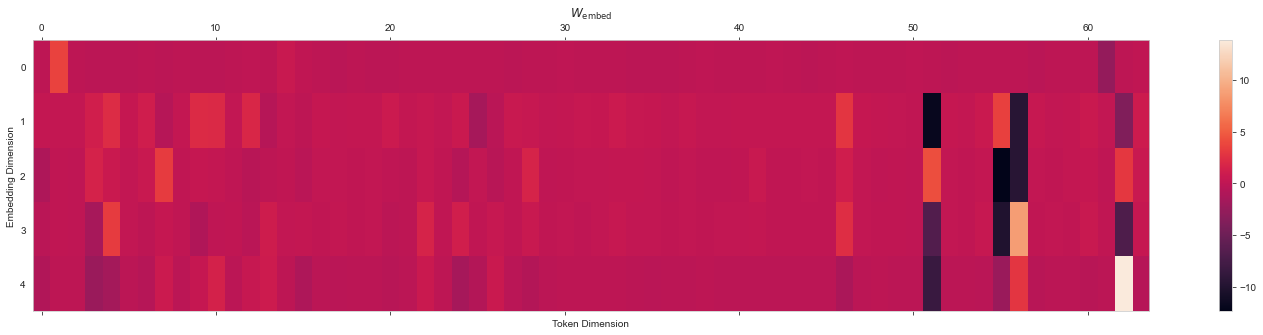

In [9]:
# Let's look at the embeddings. 

embed_weights = run.model.token_sequence_transformer.token_embedding.weight

fig, ax0 = plt.subplots(1, 1, figsize=(25, 5))

cax = ax0.matshow(embed_weights.detach().cpu().numpy().T, aspect='auto')
ax0.set_title("$W_\mathrm{embed}$")
ax0.set_xlabel("Token Dimension")
ax0.set_ylabel("Embedding Dimension")
ax0.grid(False)
fig.colorbar(cax, ax=ax0)

# ax1.bar(range(len(embed_bias)), embed_bias.detach().cpu().numpy())
# ax1.set_title("$b_\mathrm{embed}$")
# ax1.set_xlabel("Dimension")
# ax1.set_ylabel("Weight")


Text(0, 0.5, 'Weight')

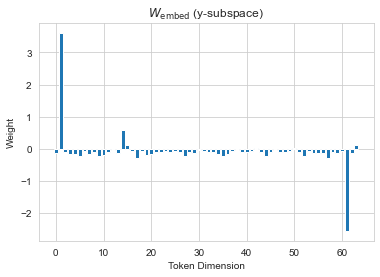

In [11]:
# Let's figure out those y encodings
plt.show()

plt.bar(range(len(embed_weights)), embed_weights.detach().cpu().numpy()[:,0])
plt.title("$W_\mathrm{embed}$ (y-subspace)")
plt.xlabel("Token Dimension")
plt.ylabel("Weight")

<ipython-input-15-aba047ba6f79>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reembedded_projections = torch.matmul(torch.tensor(projected_embeds), projection_matrix.T)


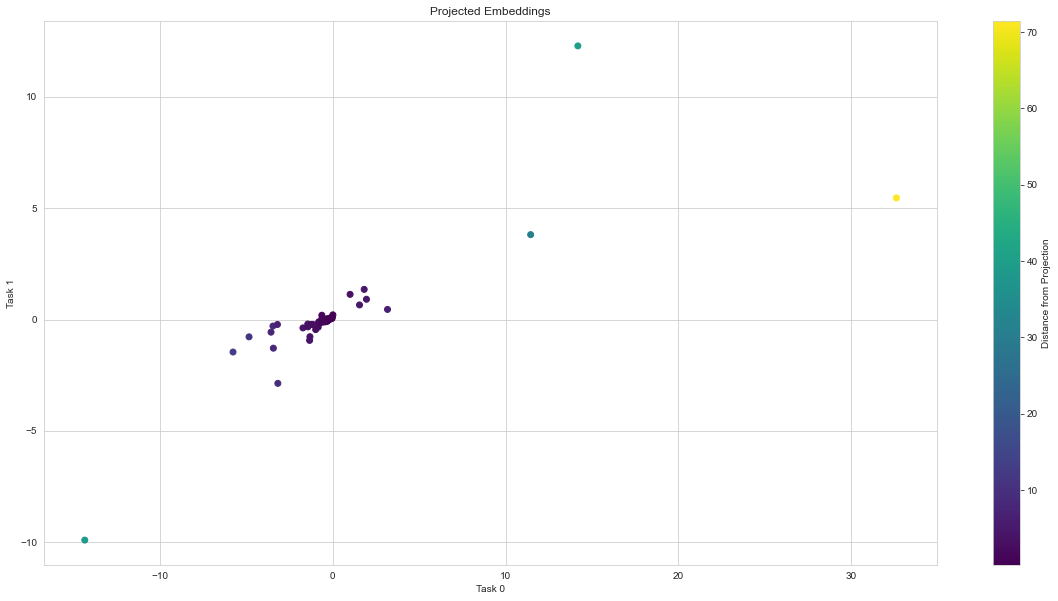

In [15]:
# Wait what I should really be doing is checking whether the embedding vectors are in the plane spanned by the tasks. If so, what are their coordinates in that plane?
tasks = run.pretrain_dist.task_distribution.tasks
x_embeds = embed_weights[:, 1:]

projection_matrix = torch.stack([tasks[0], tasks[1]], dim=1)
projected_embeds = torch.matmul(x_embeds, projection_matrix)
reembedded_projections = torch.matmul(torch.tensor(projected_embeds), projection_matrix.T)
projected_embeds = projected_embeds.detach().cpu().numpy()

# I also want to know how far from the plane they are.
dist_from_proj = np.linalg.norm(x_embeds.detach().cpu().numpy() - reembedded_projections.detach().cpu().numpy(), axis=1)
fig, ax0 = plt.subplots(1, 1, figsize=(20, 10))

cax = ax0.scatter(projected_embeds[:, 0], projected_embeds[:, 1], c=dist_from_proj, cmap='viridis')
ax0.set_title("Projected Embeddings")
ax0.set_xlabel("Task 0")
ax0.set_ylabel("Task 1")
fig.colorbar(cax, ax=ax0, label="Distance from Projection")

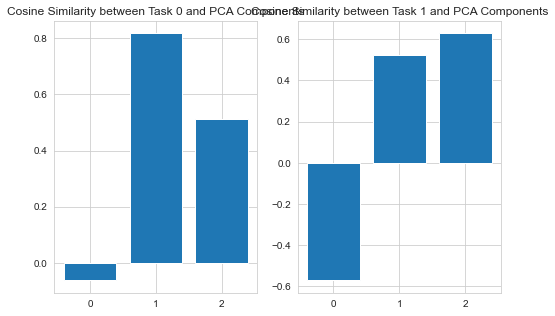

[0.25239497 0.25140807 0.2509567 ]


In [16]:
# I guess I should have just done the 3-component PCA from the start
from sklearn.decomposition import PCA
import plotly.graph_objects as go

pca = PCA(n_components=3)
pca_embeds = pca.fit_transform(x_embeds.detach().cpu().numpy())
dist_from_pca = np.linalg.norm(x_embeds.detach().cpu().numpy() - pca.inverse_transform(pca_embeds), axis=1)

# Create the 3D scatter plot using Plotly
fig = go.Figure(data=[
    go.Scatter3d(
        x=pca_embeds[:, 0],
        y=pca_embeds[:, 1],
        z=pca_embeds[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=dist_from_pca, 
            colorscale='Viridis', 
            colorbar=dict(title="Distance from PCA"),
            opacity=0.8
        )
    )
])

fig.update_layout(
    title="PCA Embeddings",
    scene=dict(
        xaxis_title="PC 1",
        yaxis_title="PC 2",
        zaxis_title="PC 3"
    )
)

fig.show()

# So the first two components match the tasks. What is the third? 

# cos sims with the PCA components
task0_pca_cos_sims = []
task1_pca_cos_sims = []

for pca_comp in pca.components_:
    task0_pca_cos_sims.append(torch.cosine_similarity(torch.tensor(pca_comp, device="mps").unsqueeze(0).unsqueeze(-1), tasks[0].unsqueeze(0).unsqueeze(-1)).item())
    task1_pca_cos_sims.append(torch.cosine_similarity(torch.tensor(pca_comp, device="mps").unsqueeze(0).unsqueeze(-1), tasks[1].unsqueeze(0).unsqueeze(-1)).item())

task0_pca_cos_sims = np.array(task0_pca_cos_sims)
task1_pca_cos_sims = np.array(task1_pca_cos_sims)
task_cross_pca_cos_sims = np.abs(task0_pca_cos_sims - task1_pca_cos_sims)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 5))

ax0.bar(range(3), task0_pca_cos_sims, label="Task 0")
ax0.set_title("Cosine Similarity between Task 0 and PCA Components")

ax1.bar(range(3), task1_pca_cos_sims, label="Task 1")
ax1.set_title("Cosine Similarity between Task 1 and PCA Components")

plt.show()

print(pca.explained_variance_ratio_)


In [ ]:
# At this point, I want more than anything to see the embeddings evolve over time. Do those extremes shoot off suddenly or not at all. But I'm going to bed. 
# Nevermind I'm going to do it

In [18]:
from tqdm import tqdm
steps = run.checkpointer.file_ids
embedding_matrices = []

for checkpoint in tqdm(run.checkpointer):
    embedding_matrices.append(checkpoint['model']['token_sequence_transformer.token_embedding.weight'])


100%|██████████| 96/96 [01:50<00:00,  1.15s/it]


In [22]:
frames = []

for step, embed in zip(steps, embedding_matrices):
    _x_embeds = embed[:, 1:].to("mps")
    projection_matrix = torch.stack([tasks[0], tasks[1]], dim=1)
    projected_embeds = torch.matmul(_x_embeds, projection_matrix)
    reembedded_projections = torch.matmul(torch.tensor(projected_embeds), projection_matrix.T)
    projected_embeds = projected_embeds.detach().cpu().numpy()
    dist_from_proj = np.linalg.norm(_x_embeds.detach().cpu().numpy() - reembedded_projections.detach().cpu().numpy(), axis=1)
    
    frame = go.Frame(
        data=[
            go.Scatter(
                x=projected_embeds[:, 0],
                y=projected_embeds[:, 1],
                mode='markers',
                marker=dict(
                    color=dist_from_proj, 
                    colorscale='Viridis', 
                    colorbar=dict(title="Distance from Projection"),
                    opacity=0.8
                )
            )
        ],
        name=str(step)
    )
    frames.append(frame)
    
# Calculate differences between successive steps for timing
diff_steps = [steps[i+1] - steps[i] for i in range(len(steps)-1)]
diff_steps.append(diff_steps[-1])  # Append the last difference for the last step

# Create steps for the slider
slider_steps = []
for i, step in enumerate(steps):
    step_duration = diff_steps[i] * 10  # Convert to milliseconds
    step_dict = {
        "args": [
            [str(step)],
            {
                "frame": {"duration": step_duration, "redraw": True},
                "mode": "immediate",
                "transition": {"duration": 10},
            },
        ],
        "label": str(step),
        "method": "animate",
    }
    slider_steps.append(step_dict)

fig = go.Figure(
    data=frames[0]['data'],
    layout=go.Layout(
        title="Projected Embeddings",
        updatemenus=[dict(type='buttons', showactive=True, buttons=[dict(label='Play', method='animate', args=[None, dict(frame=dict(duration=1000, redraw=True), fromcurrent=True)])])],
        sliders=[{"active": 0, "yanchor": "top", "xanchor": "left", "currentvalue": {"font": {"size": 20}, "prefix": "Step:", "visible": True, "xanchor": "right"}, "pad": {"b": 10, "t": 50}, "len": 0.9, "x": 0.1, "y": 0, "steps": slider_steps}],
        xaxis_title="PC 1",
        yaxis_title="PC 2",
        xaxis=dict(range=[-25, 25]),
        yaxis=dict(range=[-25, 25]),
        width=1200,  
        height=1200   
    ),
    frames=frames
)

fig.show()



<ipython-input-22-b9293a237081>:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [51]:
import numpy as np
import plotly.graph_objects as go
import torch

# Assume steps, embedding_matrices, and tasks are defined somewhere in your code

frames = []

for step, embed in zip(steps, embedding_matrices):
    _x_embeds = embed[:, 1:].to("mps")
    projection_matrix = torch.stack([tasks[0], tasks[1], tasks[2]], dim=1)  # Added a third task for 3D
    projected_embeds = torch.matmul(_x_embeds, projection_matrix)
    reembedded_projections = torch.matmul(torch.tensor(projected_embeds), projection_matrix.T)
    projected_embeds = projected_embeds.detach().cpu().numpy()
    dist_from_proj = np.linalg.norm(_x_embeds.detach().cpu().numpy() - reembedded_projections.detach().cpu().numpy(), axis=1)
    
    # Use Scatter3d for 3D scatter plot
    frame = go.Frame(
        data=[
            go.Scatter3d(
                x=projected_embeds[:, 0],
                y=projected_embeds[:, 1],
                z=projected_embeds[:, 2],  # Added the z-axis data
                mode='markers',
                marker=dict(
                    color=dist_from_proj, 
                    colorscale='Viridis', 
                    colorbar=dict(title="Distance from Projection"),
                    opacity=0.8
                )
            )
        ],
        name=str(step)
    )
    frames.append(frame)


# Create steps for the slider
slider_steps = []
for i, step in enumerate(steps):
    step_duration = diff_steps[i] * 10  # Convert to milliseconds
    step_dict = {
        "args": [
            [str(step)],
            {
                "frame": {"duration": step_duration, "redraw": True},
                "mode": "immediate",
                "transition": {"duration": 10},
            },
        ],
        "label": str(step),
        "method": "animate",
    }
    slider_steps.append(step_dict)

fig = go.Figure(
    data=frames[0]['data'],
    layout=go.Layout(
        title="Projected Embeddings",
        updatemenus=[dict(type='buttons', showactive=True, buttons=[dict(label='Play', method='animate', args=[None, dict(frame=dict(duration=1000, redraw=True), fromcurrent=True)])])],
        sliders=[{"active": 0, "yanchor": "top", "xanchor": "left", "currentvalue": {"font": {"size": 20}, "prefix": "Step:", "visible": True, "xanchor": "right"}, "pad": {"b": 10, "t": 50}, "len": 0.9, "x": 0.1, "y": 0, "steps": slider_steps}],
        xaxis_title="PC 1",
        yaxis_title="PC 2",
        xaxis=dict(range=[-25, 25]),
        yaxis=dict(range=[-25, 25]),
        width=1200,  
        height=1200   
    ),
    frames=frames
)



# Adjust layout for 3D
fig.update_layout(
    scene=dict(
        xaxis_title='Task 0',
        yaxis_title='Task 1',
        zaxis_title='Task 2',  # Added a title for the z-axis
        xaxis=dict(range=[-15, 35]),
        yaxis=dict(range=[-15, 15]),
        zaxis=dict(range=[-15, 20])  # Define range for z-axis
    ),
    width=1200,
    height=1200
)

fig.show()


<ipython-input-51-de1c3835dc08>:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



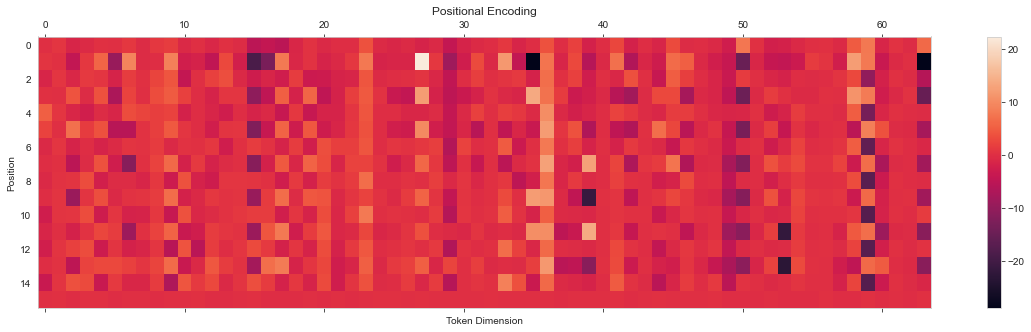

In [25]:
# Remember that the ys are also being embedded with a slight negative value. 

# Next day. Running, simplified hypothesis is something like:
# - The model embeds w_0^T x, w_1^T x, (w_0 - w_1)^T x, and y. 
# - With the QK matrix it computes C * ((w_0-w_1)^T x - y) and its negation (for some large C). 
# - With the softmax it decides which of the tasks is present. 
# - Then it copies the appropriate prediction to the prediction dimension. 

# Looking at the activation animations, it looks like the model only has to look at the first y dimension. 
# The tasks don't span the x subspace, so you only need to see one input & output to determine which you have.

# What's the positional encoding doing?

pos_enc = run.model.token_sequence_transformer.postn_embedding.weight  # No bias

fig, ax0 = plt.subplots(1, 1, figsize=(20, 5))

cax = ax0.matshow(pos_enc.detach().cpu().numpy().T, aspect='auto')
ax0.set_title("Positional Encoding")
ax0.set_xlabel("Token Dimension")
ax0.set_ylabel("Position")
ax0.grid(False)
fig.colorbar(cax, ax=ax0)


In [385]:
from torchtyping import TensorType

# The important observation is that the attention patterns don't depend on the task. There's no decision-making going on here.
# We've got a previous x-head (b0h0) and previous-token heads (b0h{1,2}) and weirder things. 

# My guess is that the main function here is to carry information from ys to xs. It's not suprising that the previous-token head b0h1 forms first. 

# I want to have a better idea of how the model's internal representations are changing. If I take a basis of R^4. And pass these as my x, then I can 
# do the same dimensionality reduction I did on the embedding weights to track how the representation changes with depth. 


TOKEN_IDX = -2

def get_representation_evolution(model, w: torch.Tensor, x0: torch.Tensor):
    _hooked_model = hook(model)
    basis = torch.eye(4, device="mps") * 1.
    # basis[1:, 1:] = 0.
    #basis[0, 0] = 0.
    #basis[2:, 2:] = 0.
    # basis[:,:] = 0.

    y0 = w @ x0

    activations_per_basis = []

    for x in basis:
        y = w @ x

        xs = torch.stack([x0, x]).unsqueeze(0)
        ys = torch.stack([y0, y]).unsqueeze(0).unsqueeze(-1)

        _activations = _hooked_model.run_with_cache(xs, ys)[1]
        
        activations_per_basis.append({
            "embed": _activations["token_sequence_transformer.token_embedding"],
            "attn0": _activations["token_sequence_transformer.blocks.0.resid_after_attn"],
            "mlp0":  _activations["token_sequence_transformer.blocks.0"],
            "attn1": _activations["token_sequence_transformer.blocks.1.resid_after_attn"],
            "mlp1":  _activations["token_sequence_transformer.blocks.1"],
            "ln": _activations["token_sequence_transformer.unembedding.0"],
        })

    # Stack them back together

    return [
        torch.stack([a["embed"] for a in activations_per_basis]),
        torch.stack([a["attn0"] for a in activations_per_basis]),
        torch.stack([a["mlp0"] for a in activations_per_basis]),
        torch.stack([a["attn1"] for a in activations_per_basis]),
        torch.stack([a["mlp1"] for a in activations_per_basis]),
        torch.stack([a["ln"] for a in activations_per_basis]),        
    ]

basis = torch.eye(4, device="mps")
task0_evoln = get_representation_evolution(run.model, tasks[0], basis[0])
task1_evoln = get_representation_evolution(run.model, tasks[1], basis[1])

def reduce_evoln(evolution: List[TensorType["dim_x", "batch_size", "num_tokens", "dim_embed"]], token_idx=TOKEN_IDX):
    evolution = [e[:,0, token_idx, :] for e in evolution]

    for i in range(len(evolution)):
        mean_i = evolution[i].mean(dim=1)
        new_evolution = torch.zeros((4, 66), device="mps")
        new_evolution[:, :64] = evolution[i]
        new_evolution[:, 64] = mean_i
        new_evolution[:, 65] = evolution[i][:, 35] - mean_i # prediction
        evolution[i] = new_evolution
        
    evoln_embedded = [torch.matmul(e.T, projection_matrix) for e in evolution]
    evoln_reembed = [torch.matmul(e, projection_matrix.T).T for e in evoln_embedded]
    evolution_with_distances = [(e_em, (e-e_rem).norm(dim=0).abs().detach().cpu().numpy()) for e_em, e_rem, e in zip(evoln_embedded, evoln_reembed, evolution)]

    return evolution_with_distances

task0_evoln = reduce_evoln(task0_evoln)
task1_evoln = reduce_evoln(task1_evoln)

In [319]:
TASK_IDX = 0
DEFAULT_LAYER = 0
task_evoln = task0_evoln if TASK_IDX == 0 else task1_evoln
print(task_evoln[0][0].shape)

torch.Size([66, 2])


In [28]:
from copy import deepcopy 
# Let's generate these same plots and also look at their evolution. 
models = []

for checkpoint in run.checkpointer:
    m = deepcopy(run.model)
    m.load_state_dict(checkpoint["model"])
    models.append(m)

models

[InContextRegressionTransformer(
   (token_sequence_transformer): DTransformer(
     (token_embedding): Linear(in_features=5, out_features=64, bias=False)
     (postn_embedding): Linear(in_features=16, out_features=64, bias=False)
     (blocks): ModuleList(
       (0-1): 2 x MultiHeadedCausalSelfAttentionTransformerBlock(
         (attention): MultiHeadedCausalSelfAttention(
           (attention): Linear(in_features=64, out_features=192, bias=False)
           (attention_softmax): Softmax(dim=-1)
         )
         (compute): Sequential(
           (0): Linear(in_features=64, out_features=64, bias=True)
           (1): ReLU()
           (2): Linear(in_features=64, out_features=64, bias=True)
         )
         (layer_norms): ModuleList(
           (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
         )
         (resid_after_attn): Identity()
       )
     )
     (unembedding): Sequential(
       (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
       (1):

In [29]:
len(models)

96

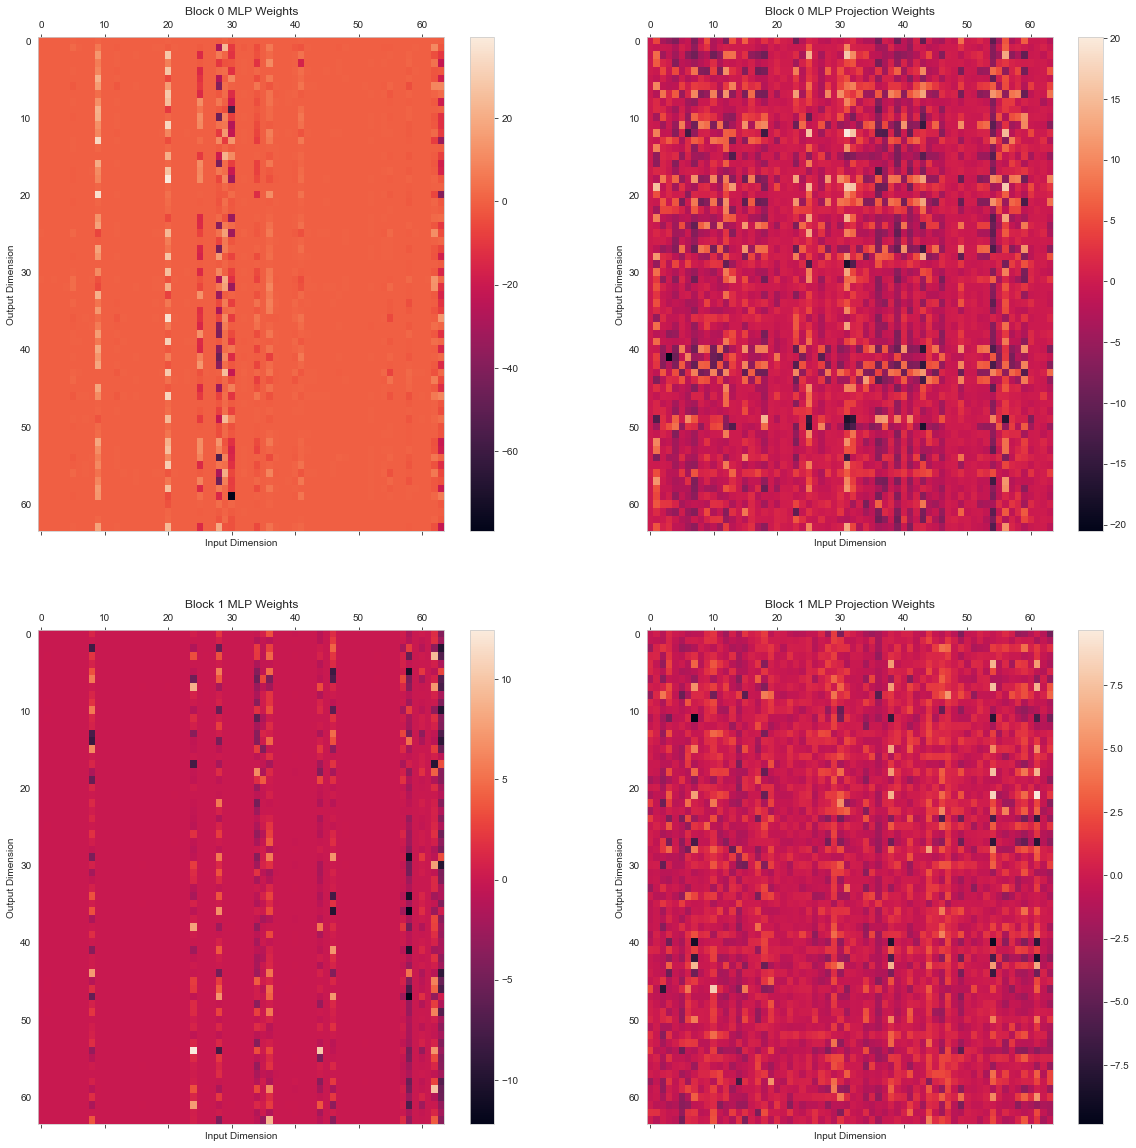

In [247]:
# Okay let's look at the last MLP
block0_mlp = run.model.token_sequence_transformer.blocks[0].compute[0]
block0_mlp_proj = run.model.token_sequence_transformer.blocks[0].compute[2]
block1_mlp = run.model.token_sequence_transformer.blocks[1].compute[0]
block1_mlp_proj = run.model.token_sequence_transformer.blocks[1].compute[2]

block0_mlp_weights = block0_mlp.weight.detach().cpu().numpy() * block0_ln1.detach().cpu().numpy()
block0_mlp_proj_weights = block0_mlp_proj.weight.detach().cpu().numpy() 
block1_mlp_weights = block1_mlp.weight.detach().cpu().numpy() * block1_ln1.detach().cpu().numpy()
block1_mlp_proj_weights = block1_mlp_proj.weight.detach().cpu().numpy()

block0_mlp_bias = block0_mlp.bias.detach().cpu().numpy()
block0_mlp_proj_bias = block0_mlp_proj.bias.detach().cpu().numpy()
block1_mlp_bias = block1_mlp.bias.detach().cpu().numpy()
block1_mlp_proj_bias = block1_mlp_proj.bias.detach().cpu().numpy()

# Matshow the last weights 

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

cax = axes[0, 0].matshow(block0_mlp_weights, aspect='auto')
axes[0, 0].set_title("Block 0 MLP Weights")
axes[0, 0].set_xlabel("Input Dimension")
axes[0, 0].set_ylabel("Output Dimension")
axes[0, 0].grid(False)
fig.colorbar(cax, ax=axes[0, 0])

cax = axes[0, 1].matshow(block0_mlp_proj_weights, aspect='auto')
axes[0, 1].set_title("Block 0 MLP Projection Weights")
axes[0, 1].set_xlabel("Input Dimension")
axes[0, 1].set_ylabel("Output Dimension")
axes[0, 1].grid(False)
fig.colorbar(cax, ax=axes[0, 1])

cax = axes[1, 0].matshow(block1_mlp_weights, aspect='auto')
axes[1, 0].set_title("Block 1 MLP Weights")
axes[1, 0].set_xlabel("Input Dimension")
axes[1, 0].set_ylabel("Output Dimension")
axes[1, 0].grid(False)
fig.colorbar(cax, ax=axes[1, 0])

cax = axes[1, 1].matshow(block1_mlp_proj_weights, aspect='auto')
axes[1, 1].set_title("Block 1 MLP Projection Weights")
axes[1, 1].set_xlabel("Input Dimension")
axes[1, 1].set_ylabel("Output Dimension")
axes[1, 1].grid(False)
fig.colorbar(cax, ax=axes[1, 1])

In [259]:
# Print ranks (tol=1e-1)

print("Block 0 MLP Weights Rank:", np.linalg.matrix_rank(block0_mlp_weights, tol=1e-1))
print("Block 0 MLP Projection Weights Rank:", np.linalg.matrix_rank(block0_mlp_proj_weights, tol=1e-1))
print("Block 1 MLP Weights Rank:", np.linalg.matrix_rank(block1_mlp_weights, tol=1e-1))
print("Block 1 MLP Projection Weights Rank:", np.linalg.matrix_rank(block1_mlp_proj_weights, tol=1e-1))

Block 0 MLP Weights Rank: 38
Block 0 MLP Projection Weights Rank: 63
Block 1 MLP Weights Rank: 19
Block 1 MLP Projection Weights Rank: 63


/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/matplotlib/transforms.py:762: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0, 0.5, 'Eigenvalue')

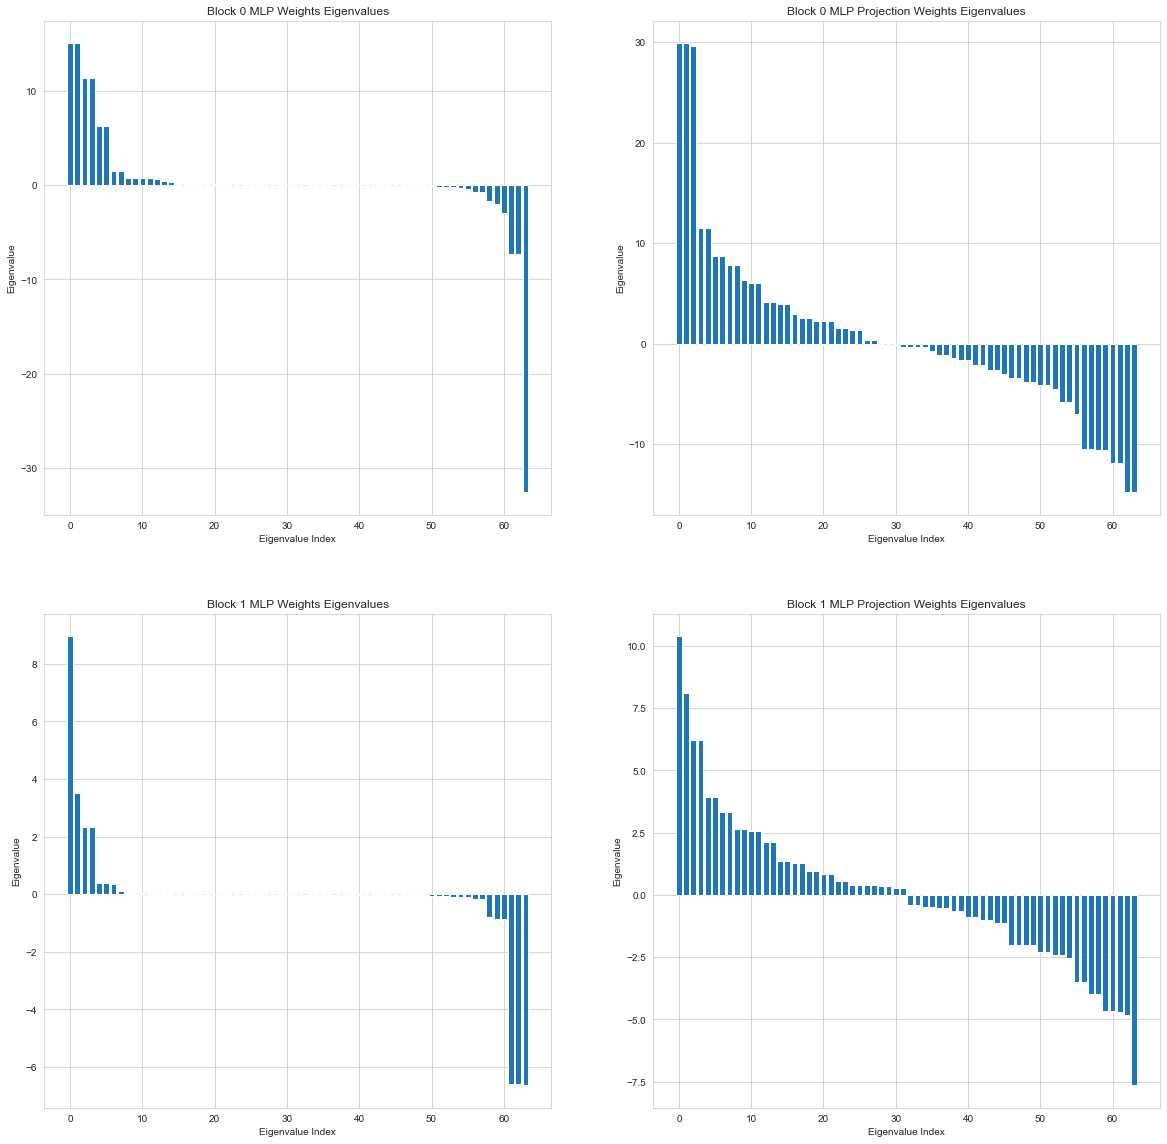

In [253]:
# Do eigenvalue decompositions and plot the eigenvalues in decreasing order

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

eigvals, eigvecs = np.linalg.eig(block0_mlp_weights)
eigvals = np.sort(eigvals)[::-1]
axes[0, 0].bar(range(len(eigvals)), eigvals)
axes[0, 0].set_title("Block 0 MLP Weights Eigenvalues")
axes[0, 0].set_xlabel("Eigenvalue Index")
axes[0, 0].set_ylabel("Eigenvalue")

eigvals, eigvecs = np.linalg.eig(block0_mlp_proj_weights)
eigvals = np.sort(eigvals)[::-1]
axes[0, 1].bar(range(len(eigvals)), eigvals)
axes[0, 1].set_title("Block 0 MLP Projection Weights Eigenvalues")
axes[0, 1].set_xlabel("Eigenvalue Index")
axes[0, 1].set_ylabel("Eigenvalue")

eigvals, eigvecs = np.linalg.eig(block1_mlp_weights)
eigvals = np.sort(eigvals)[::-1]
axes[1, 0].bar(range(len(eigvals)), eigvals)
axes[1, 0].set_title("Block 1 MLP Weights Eigenvalues")
axes[1, 0].set_xlabel("Eigenvalue Index")
axes[1, 0].set_ylabel("Eigenvalue")

eigvals, eigvecs = np.linalg.eig(block1_mlp_proj_weights)
eigvals = np.sort(eigvals)[::-1]
axes[1, 1].bar(range(len(eigvals)), eigvals)
axes[1, 1].set_title("Block 1 MLP Projection Weights Eigenvalues")
axes[1, 1].set_xlabel("Eigenvalue Index")
axes[1, 1].set_ylabel("Eigenvalue")


Text(0, 0.5, 'Output dim')

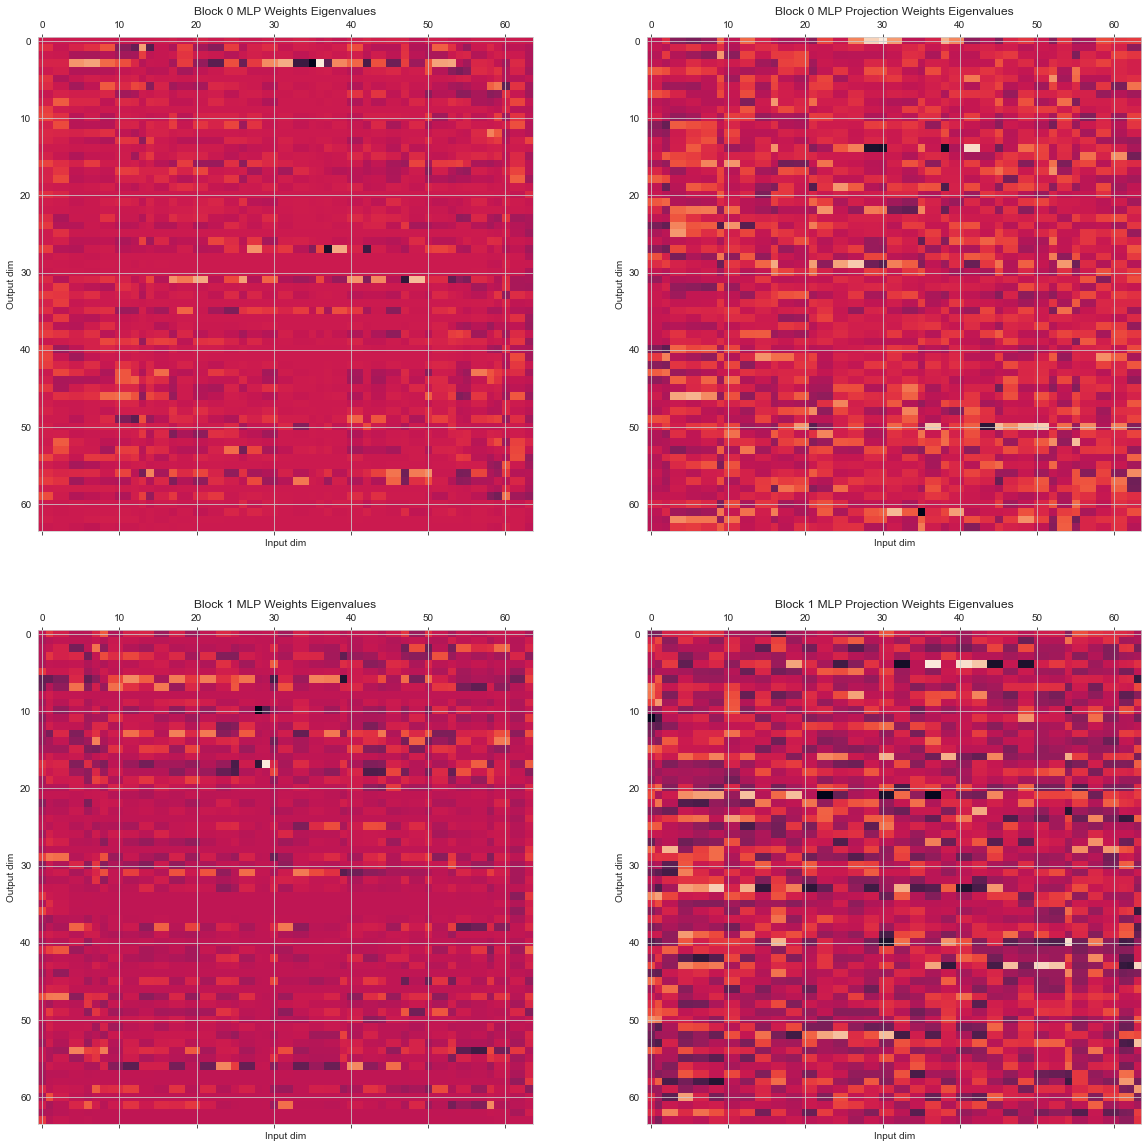

In [256]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

eigvals, eigvecs = np.linalg.eig(block0_mlp_weights)
eigval_idxs = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, eigval_idxs].real
axes[0, 0].matshow(eigvecs)
axes[0, 0].set_title("Block 0 MLP Weights Eigenvalues")
axes[0, 0].set_xlabel("Input dim")
axes[0, 0].set_ylabel("Output dim")

eigvals, eigvecs = np.linalg.eig(block0_mlp_proj_weights)
eigval_idxs = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, eigval_idxs].real
axes[0, 1].matshow(eigvecs)
axes[0, 1].set_title("Block 0 MLP Projection Weights Eigenvalues")
axes[0, 1].set_xlabel("Input dim")
axes[0, 1].set_ylabel("Output dim")

eigvals, eigvecs = np.linalg.eig(block1_mlp_weights)
eigval_idxs = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, eigval_idxs].real
axes[1, 0].matshow(eigvecs)
axes[1, 0].set_title("Block 1 MLP Weights Eigenvalues")
axes[1, 0].set_xlabel("Input dim")
axes[1, 0].set_ylabel("Output dim")

eigvals, eigvecs = np.linalg.eig(block1_mlp_proj_weights)
eigval_idxs = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, eigval_idxs].real
axes[1, 1].matshow(eigvecs)
axes[1, 1].set_title("Block 1 MLP Projection Weights Eigenvalues")
axes[1, 1].set_xlabel("Input dim")
axes[1, 1].set_ylabel("Output dim")

Text(0, 0.5, 'Weight')

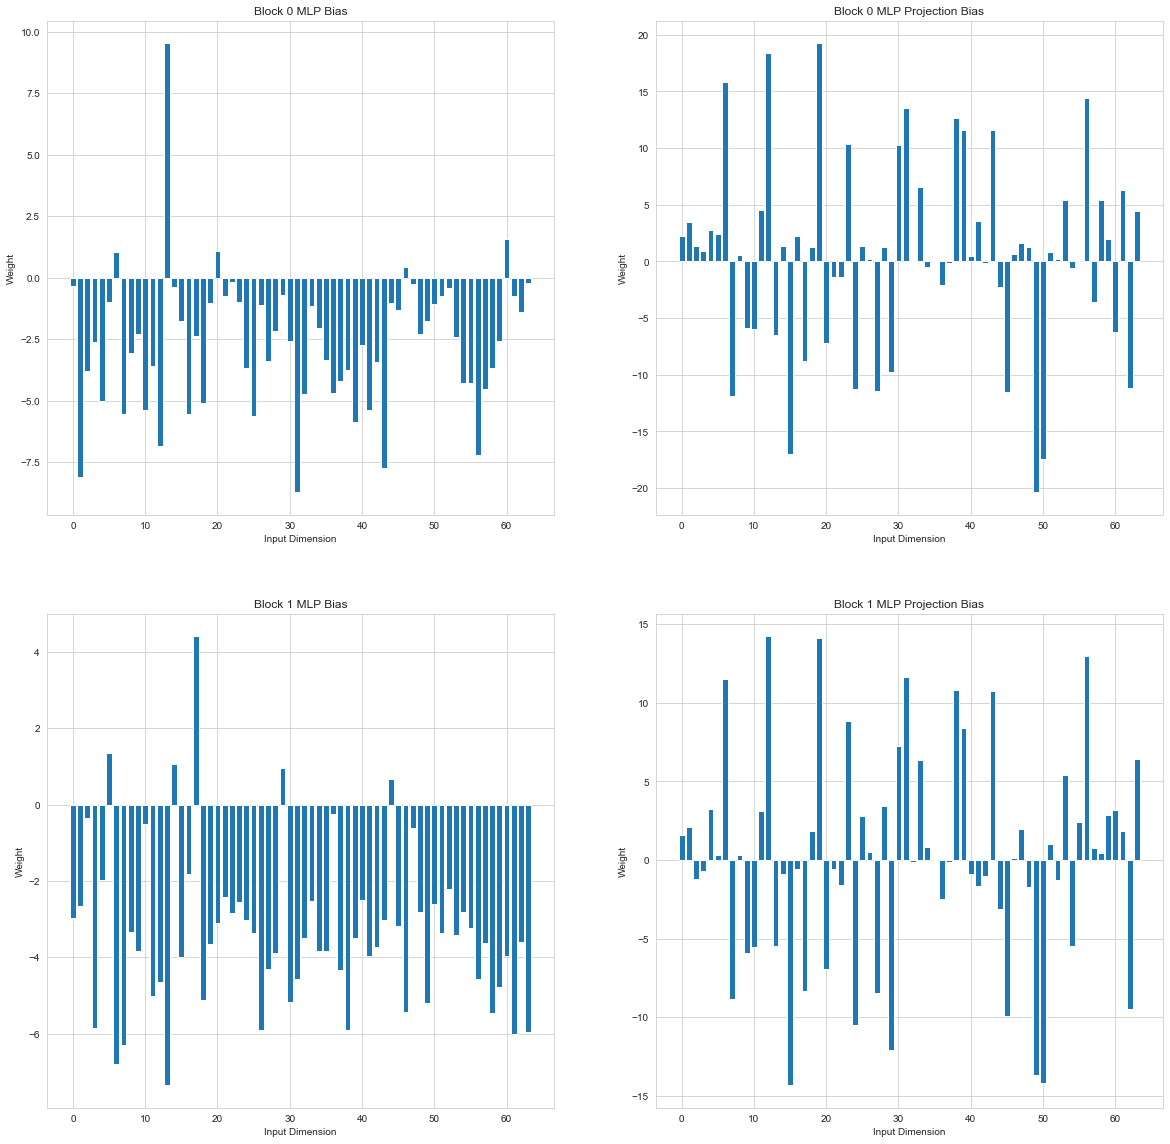

In [250]:
# Bars for the bias

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0, 0].bar(range(len(block0_mlp_bias)), block0_mlp_bias)
axes[0, 0].set_title("Block 0 MLP Bias")
axes[0, 0].set_xlabel("Input Dimension")
axes[0, 0].set_ylabel("Weight")

axes[0, 1].bar(range(len(block0_mlp_proj_bias)), block0_mlp_proj_bias)
axes[0, 1].set_title("Block 0 MLP Projection Bias")
axes[0, 1].set_xlabel("Input Dimension")
axes[0, 1].set_ylabel("Weight")

axes[1, 0].bar(range(len(block1_mlp_bias)), block1_mlp_bias)
axes[1, 0].set_title("Block 1 MLP Bias")
axes[1, 0].set_xlabel("Input Dimension")
axes[1, 0].set_ylabel("Weight")

axes[1, 1].bar(range(len(block1_mlp_proj_bias)), block1_mlp_proj_bias)
axes[1, 1].set_title("Block 1 MLP Projection Bias")
axes[1, 1].set_xlabel("Input Dimension")
axes[1, 1].set_ylabel("Weight")

In [341]:
# Okay I want to actually figure out what the slope is of that line. I realize I've been thinking of the two tasks as orthogonal this entire time when clearly they aren't. 

# Let's find an orthonormal basis in the plane spanned by the two tasks.

task_basis = torch.stack([tasks[0], tasks[1]]).T

task_basis[:, 0] = task_basis[:, 0] / task_basis[:, 0].norm()
task_basis[:, 1] = task_basis[:, 1] - task_basis[:, 1].dot(task_basis[:, 0]) * task_basis[:, 0]
task_basis[:, 1] = task_basis[:, 1] / task_basis[:, 1].norm()

task_basis_np = task_basis.detach().cpu().numpy()



tensor(0.2943, device='mps:0', grad_fn=<DivBackward0>)
tensor([[[ 0.9373],
         [-1.2660],
         [ 0.7107],
         [-0.6805],
         [-0.5675],
         [-0.5355],
         [-0.6120],
         [ 0.3257]]], device='mps:0', grad_fn=<SliceBackward0>)
tensor([[[-0.2398],
         [-1.2613],
         [ 0.7125],
         [-0.6751],
         [-0.5643],
         [-0.5250],
         [-0.6075],
         [ 0.3316]]], device='mps:0')


tensor(0.2936, device='mps:0', grad_fn=<DivBackward0>)
tensor([[[ 0.9373],
         [-1.7408],
         [ 0.8878],
         [-0.0578],
         [-0.4713],
         [ 1.8462],
         [-0.4373],
         [ 0.9938]]], device='mps:0', grad_fn=<SliceBackward0>)
tensor([[[ 2.1119],
         [-1.7419],
         [ 0.8873],
         [-0.0596],
         [-0.4721],
         [ 1.8435],
         [-0.4394],
         [ 0.9907]]], device='mps:0')


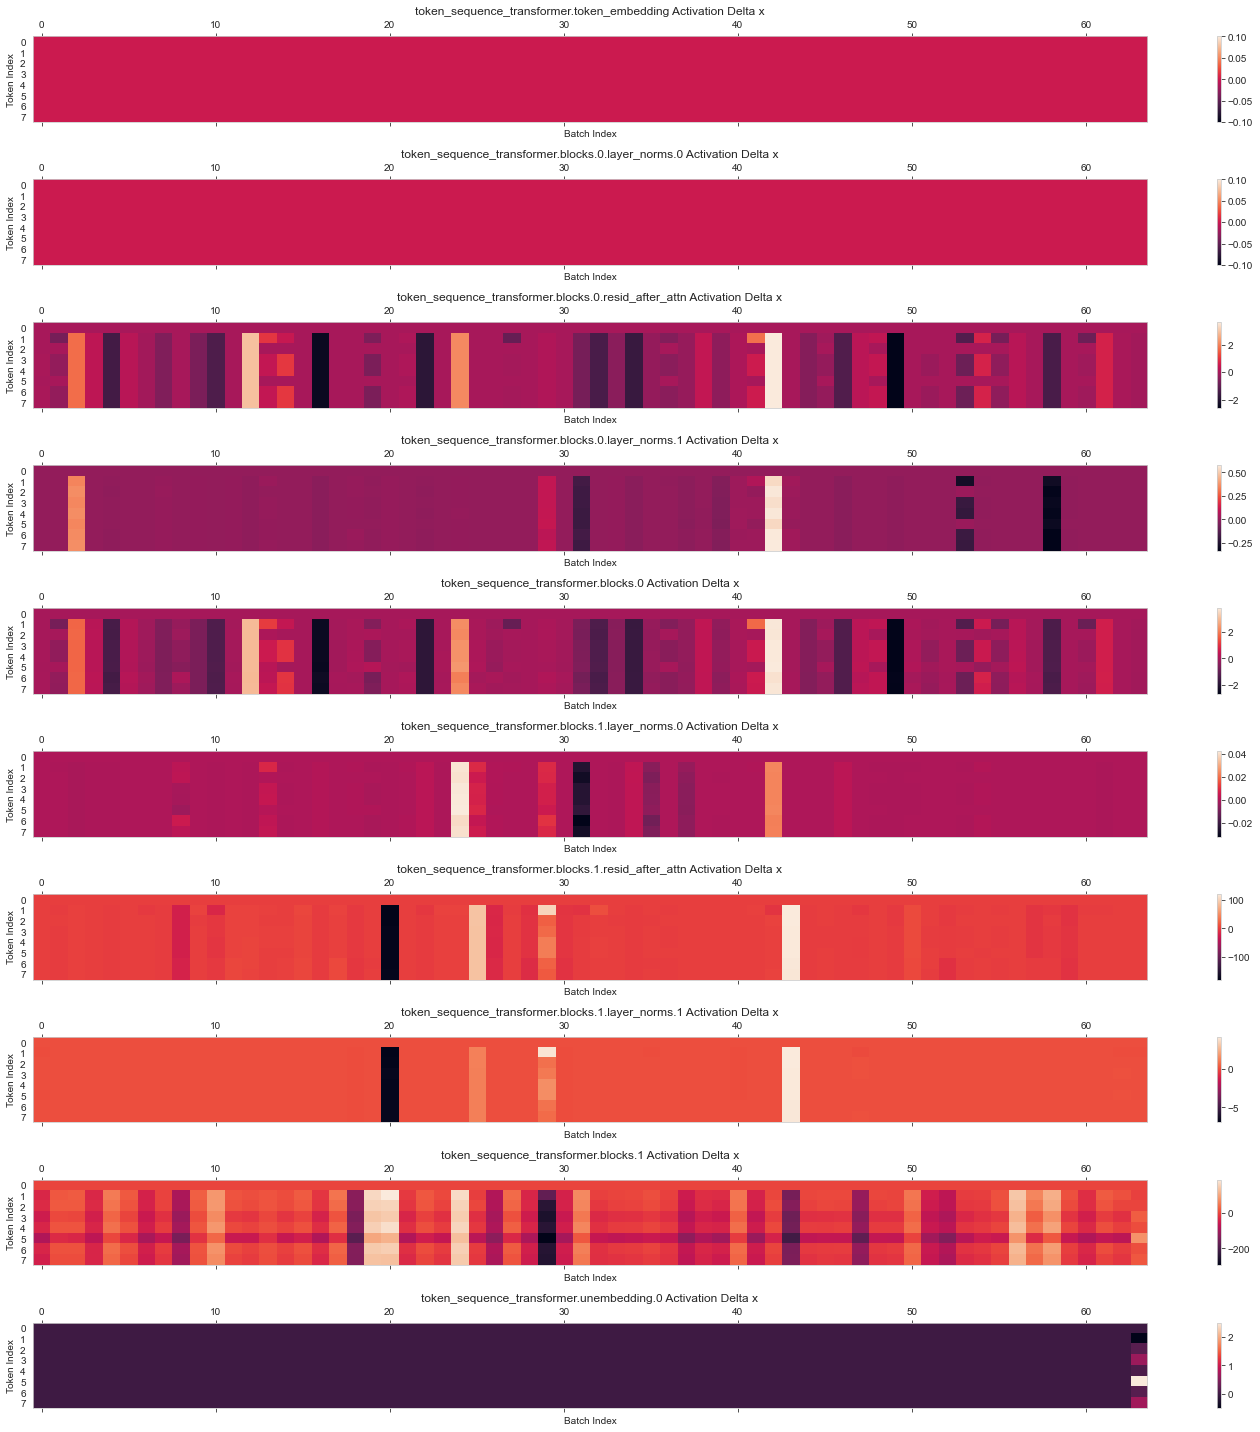

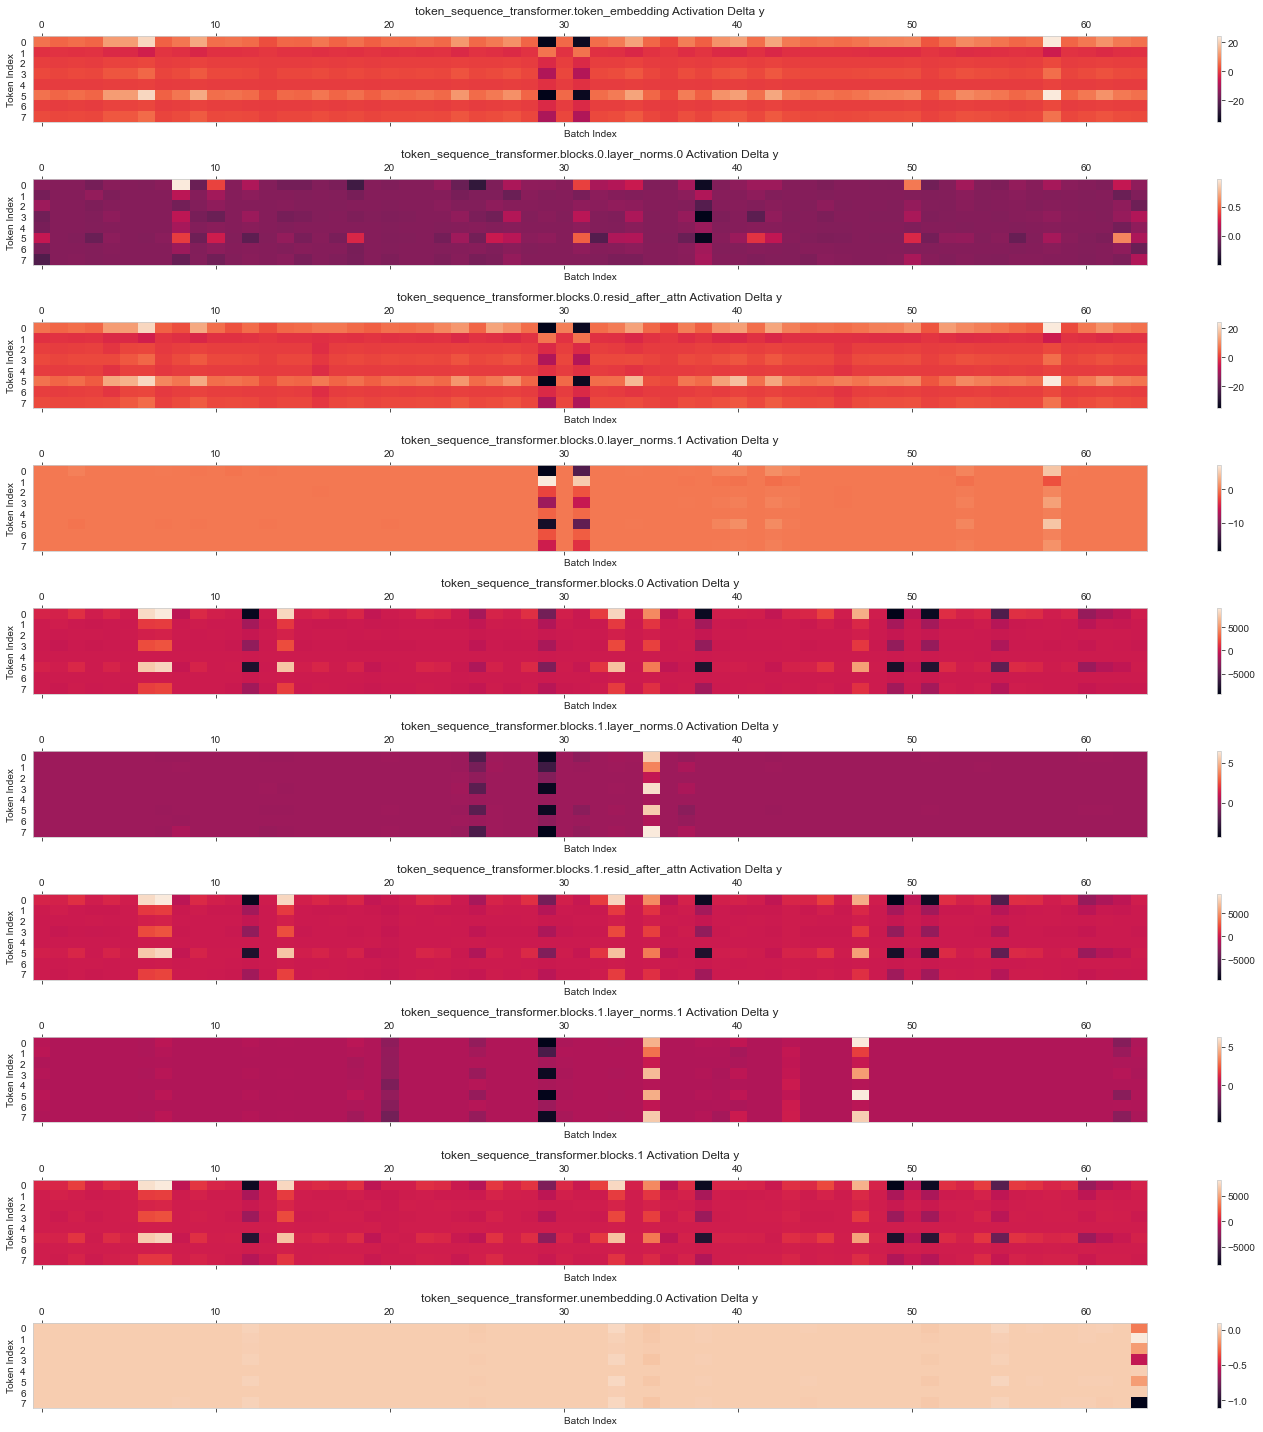

In [405]:
# Alright I want to compare the activations in the residual stream between the two tasks.

hooked_model = hook(run.model)

x0s = [torch.randn(4, device="mps") for _ in range(8)]
activations = []

for w in tasks:
    ys = []
    for x in x0s:
        ys.append(w @ x)

    xs = torch.stack(x0s).unsqueeze(0)
    ys = torch.stack(ys).unsqueeze(0).unsqueeze(-1)

    predictions, cache = hooked_model.run_with_cache(xs, ys)
    activations.append(cache)

    print("\n")
    print((predictions - ys).norm() / 4)
    print(predictions)
    print(ys)

layers = [
    "token_sequence_transformer.token_embedding",
    "token_sequence_transformer.blocks.0.layer_norms.0",
    "token_sequence_transformer.blocks.0.resid_after_attn",
    "token_sequence_transformer.blocks.0.layer_norms.1",
    "token_sequence_transformer.blocks.0",
    "token_sequence_transformer.blocks.1.layer_norms.0",
    "token_sequence_transformer.blocks.1.resid_after_attn",
    "token_sequence_transformer.blocks.1.layer_norms.1",
    "token_sequence_transformer.blocks.1",
    "token_sequence_transformer.unembedding.0"       
]

activation_deltas = [
    (activations[0][layer] - activations[1][layer])[0]
    for layer in layers
]


for x_or_y in range(2):
    fig, axes = plt.subplots(len(activation_deltas), figsize=(20, 20))

    for i, (layer, delta) in enumerate(zip(layers, activation_deltas)):
        subdelta = delta[x_or_y::2, task_line_ordering]
        cax = axes[i].matshow(subdelta.detach().cpu().numpy(), aspect='auto')
        axes[i].set_title(f"{layer} Activation Delta {'x' if x_or_y == 0 else 'y'}")
        axes[i].set_xlabel("Batch Index")
        axes[i].set_ylabel("Token Index")
        axes[i].grid(False)
        fig.colorbar(cax, ax=axes[i])
        

    plt.tight_layout()
    plt.show()

In [44]:
from icl.tasks import apply_transformations

# I'd like to see how close the model gets to predicting the centroid of the two tasks as a function of steps and tokens. 
B = 2048
K = 8
D = 4
DEVICE = "mps"
datasets = []

task_avg = tasks.sum(dim=0) / num_tasks

wmids = task_avg.unsqueeze(0).repeat(B, 1, 1)

# sample i.i.d. inputs and outputs for each task according to the
# regression model
xs = torch.normal(
    mean=0.,
    std=1.,
    size=(B, K, D,),
    device=DEVICE,
)

ymids = apply_transformations(wmids, xs, 0., DEVICE)
ws = run.pretrain_dist.task_distribution.sample_tasks(B)
ys = apply_transformations(ws, xs, 0., DEVICE)


In [40]:
task_avg

tensor([ 0.0011, -0.0003, -0.0019,  0.0001], device='mps:0')

In [45]:
pred_distances = pd.DataFrame(columns=["step", "mse", "delta_mid"] + [f"token_{i}/mse" for i in range(8)] + [f"token_{i}/delta_mid" for i in range(8)])

for step, model in zip(run.checkpointer.file_ids, models):
    yhats = model(xs, ys)
    mse_per_token = ((yhats - ys) ** 2).mean(dim=0).mean(dim=-1)
    mse = mse_per_token.mean()

    delta_mid_per_token = ((yhats - ymids) ** 2).mean(dim=0).mean(dim=-1)
    delta_mid = delta_mid_per_token.mean()

    pred_distances = pred_distances.append({
        "step": step + 1,
        "mse": mse.item(),
        "delta_mid": delta_mid.item(),
        **{f"token_{t}/mse": mse_per_token[t].item() for t in range(8)},
        **{f"token_{t}/delta_mid": delta_mid_per_token[t].item() for t in range(8)},
    }, ignore_index=True)
            

<ipython-input-45-18cdc21cd00e>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-45-18cdc21cd00e>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-45-18cdc21cd00e>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-45-18cdc21cd00e>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-45-18cdc21cd00e>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-45-18cdc21cd00e>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

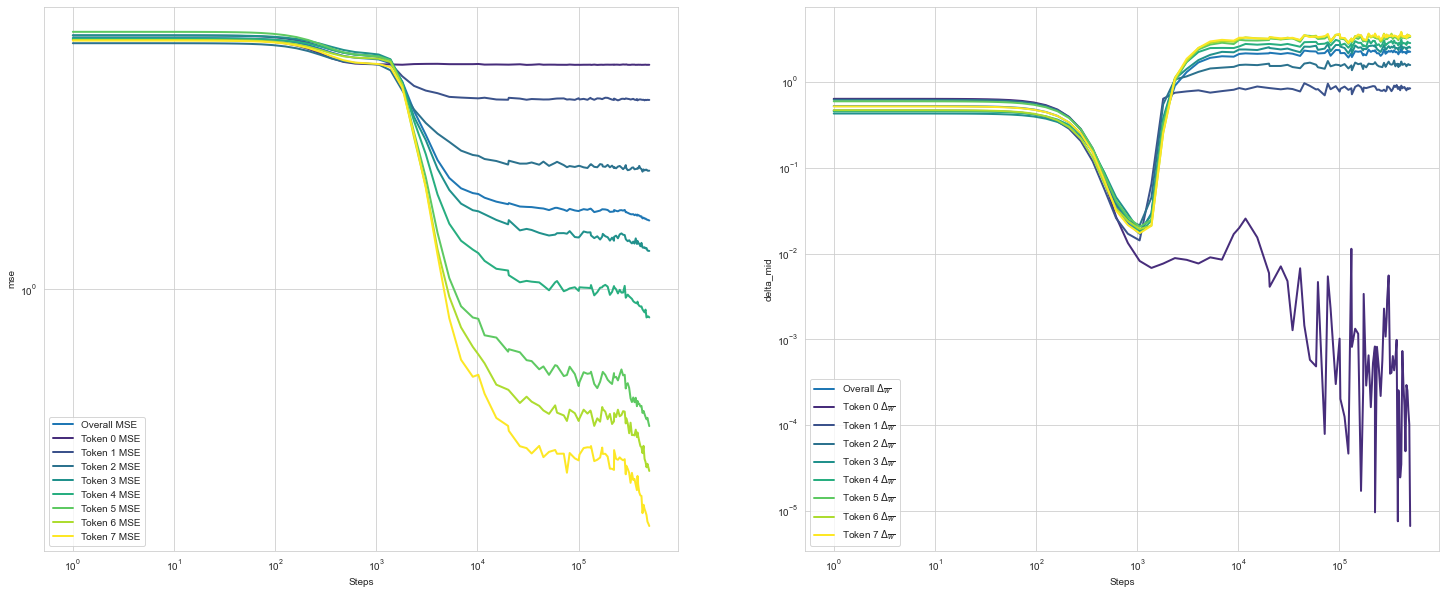

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

labels = {"mse": "MSE", "delta_mid": "$\Delta_{\overline{w}}$"} 

# Generate 2x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

for ax in axes:
    ax.grid(True)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("Steps")

# Use viridis colormap
cmap = plt.cm.viridis

metrics = ["mse", "delta_mid"]

for i, metric in enumerate(metrics):
    # First column: step on x-axis
    sns.lineplot(data=pred_distances, x='step', y=metric, ax=axes[i], label=f'Overall {labels[metric]}', linewidth=2)

    for j in range(8):
        sns.lineplot(data=pred_distances, x='step', y=f'token_{j}/{metric}', ax=axes[i], label=f'Token {j} {labels[metric]}', color=cmap((j+1)/8), linewidth=2)

for ax in axes:
    ax.legend()

fig.set_facecolor('white')
plt.show()

In [53]:
from plotly.subplots import make_subplots 

# Let's look at the 5 layer norms over time

ln_layers = [
    "token_sequence_transformer.blocks.0.layer_norms.0",
    "token_sequence_transformer.blocks.0.layer_norms.1",
    "token_sequence_transformer.blocks.1.layer_norms.0",
    "token_sequence_transformer.blocks.1.layer_norms.1",
    "token_sequence_transformer.unembedding.0"
]

lns_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    for layer in ln_layers:
        lns_over_time.append({
            "step": step,
            "layer": layer,
            "weight": model.state_dict()[layer + ".weight"].detach().cpu().numpy(),
            "bias": model.state_dict()[layer + ".bias"].detach().cpu().numpy()
        })

lns_over_time = pd.DataFrame(lns_over_time)

max_y_weight = {}
max_y_bias = {}
for layer in ln_layers:
    all_weights = [item for item in lns_over_time.loc[lns_over_time['layer'] == layer]['weight']]
    all_biases = [item for item in lns_over_time.loc[lns_over_time['layer'] == layer]['bias']]
    max_y_weight[layer] = max([val.max() for val in all_weights])
    max_y_bias[layer] = max([val.max() for val in all_biases])


# Initialize subplots, 2 rows (for weight and bias) and 5 columns (for each layer)
fig = make_subplots(rows=2, cols=5, subplot_titles=[(".").join(ln_layer.replace("layer_norms", "ln").split('.')[1:]) + ".weight" for ln_layer in ln_layers] + [(".").join(ln_layer.replace("layer_norms", "ln").split('.')[1:]) + ".bias" for ln_layer in ln_layers])

for index, layer in enumerate(ln_layers):
    initial_data = lns_over_time[(lns_over_time['layer'] == layer) & (lns_over_time['step'] == 0)]
    
    # Weight bar plot
    fig.add_trace(
        go.Bar(x=list(range(len(initial_data['weight'].iloc[0]))), y=initial_data['weight'].iloc[0]),
        row=1, col=index+1
    )
    fig.update_yaxes(range=[0, max_y_weight[layer]], row=1, col=index+1)
    
    # Bias bar plot
    fig.add_trace(
        go.Bar(x=list(range(len(initial_data['bias'].iloc[0]))), y=initial_data['bias'].iloc[0]),
        row=2, col=index+1
    )
    fig.update_yaxes(range=[0, max_y_bias[layer]], row=2, col=index+1)

# Define animation frames
frames = []
for step in lns_over_time['step'].unique():
    frame_data = []
    
    for index, layer in enumerate(ln_layers):
        step_data = lns_over_time[(lns_over_time['layer'] == layer) & (lns_over_time['step'] == step)]
        
        # Weight
        frame_data.append(go.Bar(x=list(range(len(step_data['weight'].iloc[0]))), y=step_data['weight'].iloc[0]))
        
        # Bias
        frame_data.append(go.Bar(x=list(range(len(step_data['bias'].iloc[0]))), y=step_data['bias'].iloc[0]))
    
    frames.append(go.Frame(data=frame_data, name=f"Step {step}"))

fig.frames = frames

# Add play and pause buttons
animation_settings = dict(frame=dict(duration=300, redraw=True), fromcurrent=True)
fig.update_layout(updatemenus=[dict(type="buttons", showactive=False, buttons=[dict(label="Play",
                                            method="animate", args=[None, animation_settings]),
                                          dict(label="Pause", method="animate", args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")])])])


# Add sliders
sliders = [dict(steps=[dict(method='animate', args=[[f'Step {s}'], dict(mode='immediate', frame=dict(duration=300, redraw=True))], label=f'Step {s}') for s in lns_over_time['step'].unique()], active=0)]

fig.update_layout(sliders=sliders)

# Show figure
fig.show()

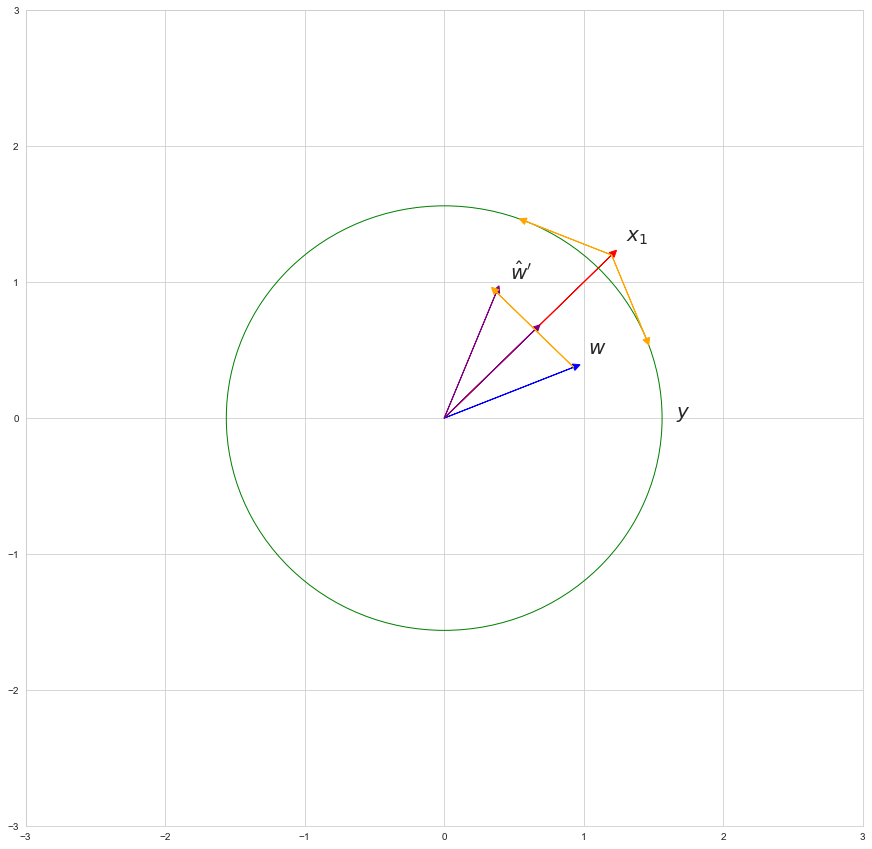

|w_+| tensor(0.9204) y tensor(1.5619) tensor(1.6971) tensor(0.9204)


In [152]:
# Let's try to understand ridge regression geometrically for k < D

# 1. Assume task vectors are unit vectors distributed uniformly on the unit sphere.
# Given a single input-output pair (x_1, y_1), what is the optimal prediction you can make?
# No noise to outputs

torch.manual_seed(1)

x_1 = torch.ones(2) * 1.2 # torch.randn(2, device="cpu")
w_true =  torch.randn(2, device="cpu")
w_true = w_true / w_true.norm()
y = w_true @ x_1

# Plot as arrows

fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.arrow(0, 0, x_1[0], x_1[1], head_width=0.05, head_length=0.05, color='red')
ax.arrow(0, 0, w_true[0], w_true[1], head_width=0.05, head_length=0.05, color='blue')

# Plot a circle with radius y

circle = plt.Circle((0, 0), y, color='green', fill=False)
ax.add_patch(circle)

# Flip w_true about x_1 to generate the other possible candidate w (when given only 1 y)
w_2 = - w_true + 2 * (w_true @ x_1) * x_1 / (x_1 @ x_1)
ax.arrow(0, 0, w_2[0], w_2[1], head_width=0.05, head_length=0.05, color='purple')

w_sum = (w_true + w_2) / 2.
ax.arrow(0, 0, w_sum[0], w_sum[1], head_width=0.05, head_length=0.05, color='purple')

w_diff = - w_true + w_2
ax.arrow(w_true[0], w_true[1], w_diff[0], w_diff[1], head_width=0.05, head_length=0.05, color='orange')


# Plot the line showing the projection of x_1 onto w_true and w_1
orthogonal_true = -(x_1 - y * w_true)
orthogonal_2 =  -(x_1 - y * w_2)

ax.arrow(x_1[0], x_1[1], orthogonal_true[0],  orthogonal_true[1], head_width=0.05, head_length=0.05, color='orange')
ax.arrow(x_1[0], x_1[1],  orthogonal_2[0],  orthogonal_2[1], head_width=0.05, head_length=0.05, color='orange')

# Label the arrows
ax.text(x_1[0] + 0.1, x_1[1] + 0.1, "$x_1$", fontsize=20)
ax.text(w_true[0] + 0.1, w_true[1] + 0.1, "$w$", fontsize=20)
ax.text(w_2[0] + 0.1, w_2[1] + 0.1, "$\hat w'$", fontsize=20)
ax.text(y+.1, 0, "$y$", fontsize=20)

LIM = 3

ax.set_xlim(-LIM, LIM)
ax.set_ylim(-LIM, LIM)

plt.show()

print("|w_+|", w_sum.norm(), "y", y, x_1.norm(), y / x_1.norm())

|w_+| tensor(0.9204)
tensor(0.2897) tensor(0.5992) tensor(0.4445) tensor(0.4445)


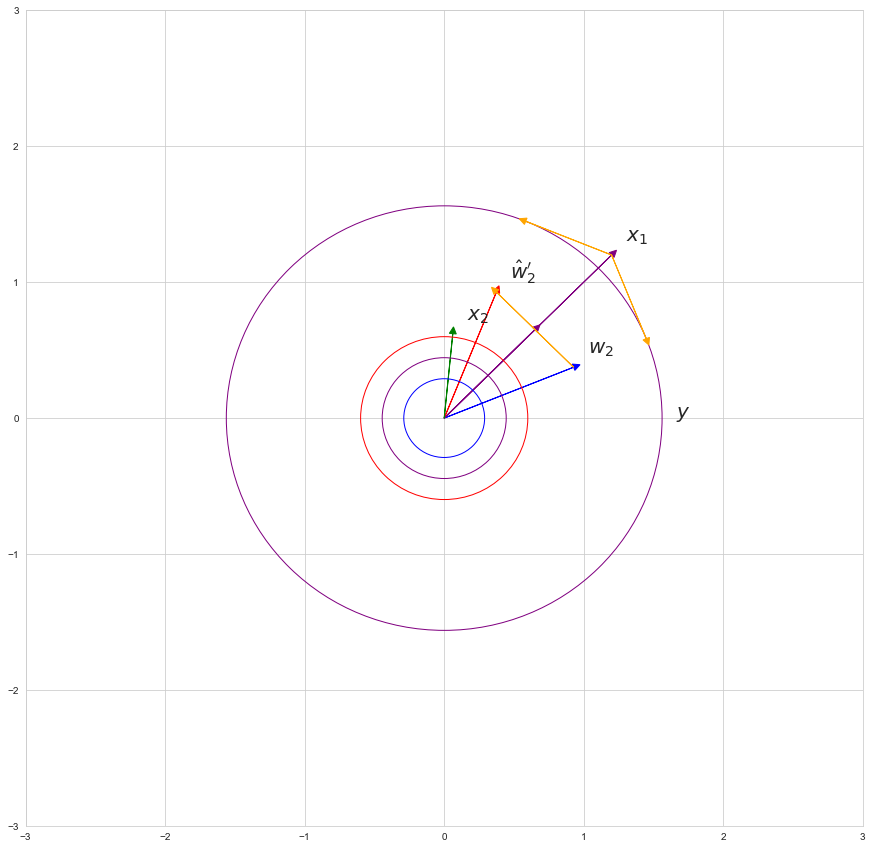

In [164]:
# Let's see what happens when we add a second sample. The ideal prediction should be to use the task sum vector.

torch.manual_seed(1)

x_1 = torch.ones(2) * 1.2 # torch.randn(2, device="cpu")
w_true =  torch.randn(2, device="cpu")
w_true = w_true / w_true.norm()
y = w_true @ x_1

# Plot as arrows

fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.arrow(0, 0, x_1[0], x_1[1], head_width=0.05, head_length=0.05, color='purple')
ax.arrow(0, 0, w_true[0], w_true[1], head_width=0.05, head_length=0.05, color='blue')

# Plot a circle with radius y

circle = plt.Circle((0, 0), y, color='purple', fill=False, linestyle='dashed' if y < 0 else 'solid')
ax.add_patch(circle)

# Flip w_true about x_1 to generate the other possible candidate w (when given only 1 y)
w_2 = - w_true + 2 * (w_true @ x_1) * x_1 / (x_1 @ x_1)
ax.arrow(0, 0, w_2[0], w_2[1], head_width=0.05, head_length=0.05, color='red')

w_sum = (w_true + w_2) / 2.
ax.arrow(0, 0, w_sum[0], w_sum[1], head_width=0.05, head_length=0.05, color='purple')

w_diff = - w_true + w_2
ax.arrow(w_true[0], w_true[1], w_diff[0], w_diff[1], head_width=0.05, head_length=0.05, color='orange')


# Plot the line showing the projection of x_1 onto w_true and w_1
orthogonal_true = -(x_1 - y * w_true)
orthogonal_2 =  -(x_1 - y * w_2)

ax.arrow(x_1[0], x_1[1], orthogonal_true[0],  orthogonal_true[1], head_width=0.05, head_length=0.05, color='orange')
ax.arrow(x_1[0], x_1[1],  orthogonal_2[0],  orthogonal_2[1], head_width=0.05, head_length=0.05, color='orange')

# Label the arrows
ax.text(x_1[0] + 0.1, x_1[1] + 0.1, "$x_1$", fontsize=20)
ax.text(w_true[0] + 0.1, w_true[1] + 0.1, "$w_2$", fontsize=20)
ax.text(w_2[0] + 0.1, w_2[1] + 0.1, "$\hat w_2'$", fontsize=20)
ax.text(y+.1, 0, "$y$", fontsize=20)

LIM = 3

ax.set_xlim(-LIM, LIM)
ax.set_ylim(-LIM, LIM)

print("|w_+|", w_sum.norm())

x_2 = torch.randn(2, device="cpu")

ax.arrow(0, 0, x_2[0], x_2[1], head_width=0.05, head_length=0.05, color='green')
ax.text(x_2[0] + 0.1, x_2[1] + 0.1, "$x_2$", fontsize=20)

y_2_true = w_true @ x_2
y_2_alt = w_2 @ x_2
y_2_mid = w_sum @ x_2 

# Plot circles with radius y_2_true and y_2_alt

circle = plt.Circle((0, 0), y_2_true, color='blue', fill=False, linestyle='dashed' if y_2_true < 0 else 'solid')
ax.add_patch(circle)

circle = plt.Circle((0, 0), y_2_alt, color='red', fill=False, linestyle='dashed' if y_2_alt < 0 else 'solid')
ax.add_patch(circle)

circle = plt.Circle((0, 0), y_2_mid, color='purple', fill=False, linestyle='dashed' if y_2_mid < 0 else 'solid')
ax.add_patch(circle)

print(y_2_true, y_2_alt, y_2_mid, (y_2_true + y_2_alt) / 2.)


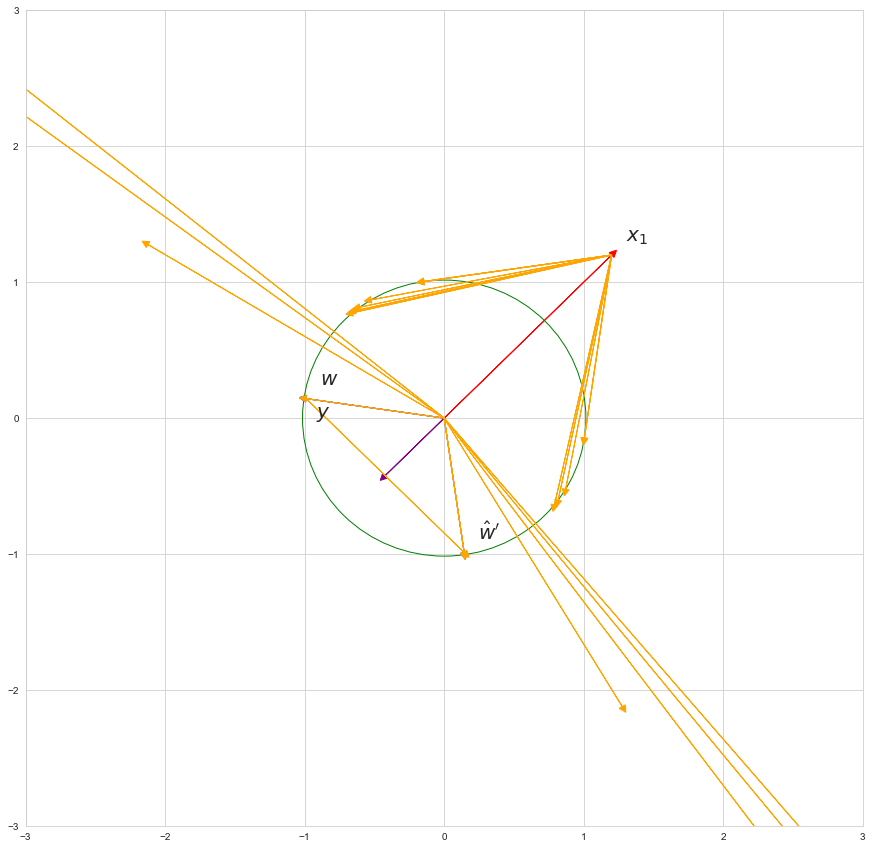

|w_+| tensor(0.5985)


In [154]:
# 2. Let's allow the task vectors to have variable magnitude, with components sampled from a normal distribution with mean 0 and variance 1.

torch.manual_seed(4)

x_1 = torch.ones(2) * 1.2 # torch.randn(2, device="cpu")
w_true =  torch.randn(2, device="cpu")
w_true = w_true / w_true.norm()
y = w_true @ x_1

# Plot as arrows

fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.arrow(0, 0, x_1[0], x_1[1], head_width=0.05, head_length=0.05, color='red')
ax.arrow(0, 0, w_true[0], w_true[1], head_width=0.05, head_length=0.05, color='blue')

# Plot a circle with radius y

circle = plt.Circle((0, 0), y, color='green', fill=False)
ax.add_patch(circle)

# Flip w_true about x_1 to generate the other possible candidate w (when given only 1 y)
w_2 = - w_true + 2 * (w_true @ x_1) * x_1 / (x_1 @ x_1)
ax.arrow(0, 0, w_2[0], w_2[1], head_width=0.05, head_length=0.05, color='purple')

w_sum = (w_true + w_2) / 2.
ax.arrow(0, 0, w_sum[0], w_sum[1], head_width=0.05, head_length=0.05, color='purple')

w_diff = - w_true + w_2
ax.arrow(w_true[0], w_true[1], w_diff[0], w_diff[1], head_width=0.05, head_length=0.05, color='orange')

# Plot the line showing the projection of x_1 onto w_true and w_1
orthogonal_true = -(x_1 - y * w_true)
orthogonal_2 =  -(x_1 - y * w_2)

ax.arrow(x_1[0], x_1[1], orthogonal_true[0],  orthogonal_true[1], head_width=0.05, head_length=0.05, color='orange')
ax.arrow(x_1[0], x_1[1],  orthogonal_2[0],  orthogonal_2[1], head_width=0.05, head_length=0.05, color='orange')

for i in range(5):
    w_i = w_2 - i * w_diff
    orthogonal_i = -(x_1 - y * w_i / w_i.norm())
    ax.arrow(0, 0, w_i[0], w_i[1], head_width=0.05, head_length=0.05, color='orange')
    ax.arrow(x_1[0], x_1[1], orthogonal_i[0],  orthogonal_i[1], head_width=0.05, head_length=0.05, color='orange')

    w_i = w_2 + i * w_diff
    orthogonal_i = -(x_1 - y * w_i / w_i.norm())
    ax.arrow(0, 0, w_i[0], w_i[1], head_width=0.05, head_length=0.05, color='orange')
    ax.arrow(x_1[0], x_1[1], orthogonal_i[0],  orthogonal_i[1], head_width=0.05, head_length=0.05, color='orange')

# Label the arrows
ax.text(x_1[0] + 0.1, x_1[1] + 0.1, "$x_1$", fontsize=20)
ax.text(w_true[0] + 0.1, w_true[1] + 0.1, "$w$", fontsize=20)
ax.text(w_2[0] + 0.1, w_2[1] + 0.1, "$\hat w'$", fontsize=20)
ax.text(y+.1, 0, "$y$", fontsize=20)

LIM = 3

ax.set_xlim(-LIM, LIM)
ax.set_ylim(-LIM, LIM)

plt.show()

print("|w_+|", w_sum.norm())

InContextRegressionTransformer(
  (token_sequence_transformer): DTransformer(
    (token_embedding): Linear(in_features=5, out_features=64, bias=False)
    (postn_embedding): Linear(in_features=16, out_features=64, bias=False)
    (blocks): ModuleList(
      (0-1): 2 x MultiHeadedCausalSelfAttentionTransformerBlock(
        (attention): MultiHeadedCausalSelfAttention(
          (attention): Linear(in_features=64, out_features=192, bias=False)
          (attention_softmax): Softmax(dim=-1)
        )
        (compute): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
        (layer_norms): ModuleList(
          (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (resid_after_attn): Identity()
      )
    )
    (unembedding): Sequential(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=64, 

torch.Size([4]) torch.Size([8, 4]) torch.Size([8, 1]) torch.Size([2, 4])
torch.Size([1, 4])
tensor([-0.6773,  0.4974, -0.5332,  0.9093], device='mps:0') tensor([-0.6612,  0.4856, -0.5206,  0.8878], device='mps:0')

Prediction
tensor([-2.2189], device='mps:0') tensor([-0.6652], device='mps:0', grad_fn=<SelectBackward0>) tensor(-0.6624, device='mps:0') tensor(-0.6467, device='mps:0')
[torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4])]


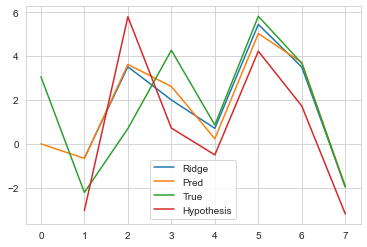

torch.Size([7]) torch.Size([8, 1])


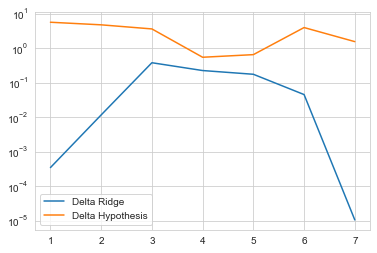

torch.Size([4]) torch.Size([8, 4]) torch.Size([8, 1]) torch.Size([2, 4])
torch.Size([1, 4])
tensor([-0.8456, -0.3907, -0.1967, -0.5177], device='mps:0') tensor([-0.8050, -0.3719, -0.1873, -0.4929], device='mps:0')

Prediction
tensor([0.7627], device='mps:0') tensor([-0.0019], device='mps:0', grad_fn=<SelectBackward0>) tensor(-0.0079, device='mps:0') tensor(-0.0075, device='mps:0')
[torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4])]


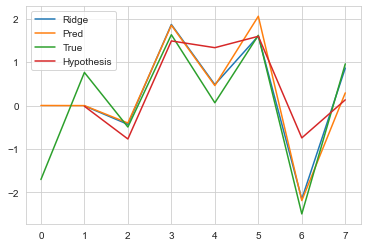

torch.Size([7]) torch.Size([8, 1])


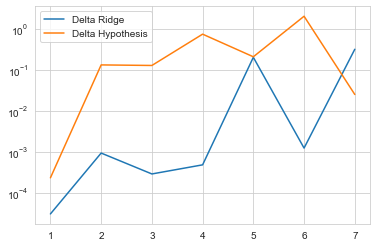

torch.Size([4]) torch.Size([8, 4]) torch.Size([8, 1]) torch.Size([2, 4])
torch.Size([1, 4])
tensor([ 0.2015, -0.0250,  0.2360, -0.5670], device='mps:0') tensor([ 0.1956, -0.0243,  0.2291, -0.5505], device='mps:0')

Prediction
tensor([-0.1362], device='mps:0') tensor([-0.1992], device='mps:0', grad_fn=<SelectBackward0>) tensor(-0.2213, device='mps:0') tensor(-0.2148, device='mps:0')
[torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4])]


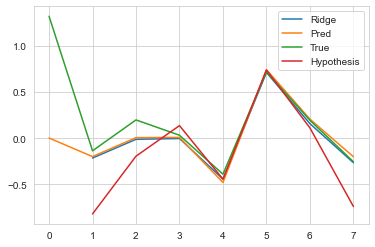

torch.Size([7]) torch.Size([8, 1])


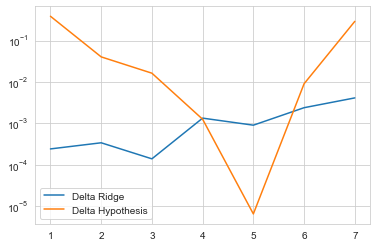

torch.Size([4]) torch.Size([8, 4]) torch.Size([8, 1]) torch.Size([2, 4])
torch.Size([1, 4])
tensor([-0.7095,  0.1974,  0.1813,  0.1302], device='mps:0') tensor([-0.6829,  0.1900,  0.1745,  0.1253], device='mps:0')

Prediction
tensor([0.2933], device='mps:0') tensor([0.3412], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.3294, device='mps:0') tensor(0.3170, device='mps:0')
[torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4])]


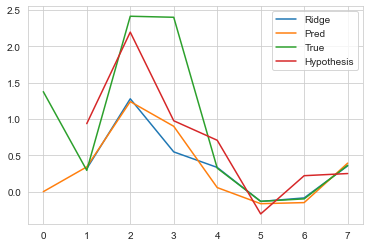

torch.Size([7]) torch.Size([8, 1])


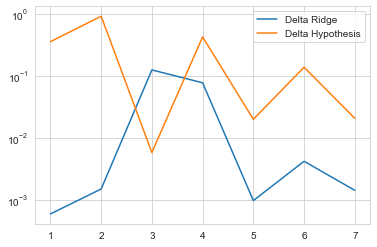

torch.Size([4]) torch.Size([8, 4]) torch.Size([8, 1]) torch.Size([2, 4])
torch.Size([1, 4])
tensor([ 0.2078, -0.1046,  0.0680, -0.1247], device='mps:0') tensor([ 0.1987, -0.1001,  0.0650, -0.1192], device='mps:0')

Prediction
tensor([-6.7638], device='mps:0') tensor([-0.3290], device='mps:0', grad_fn=<SelectBackward0>) tensor(-0.3496, device='mps:0') tensor(-0.3343, device='mps:0')
[torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4]), torch.Size([4])]


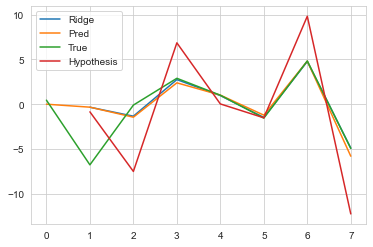

torch.Size([7]) torch.Size([8, 1])


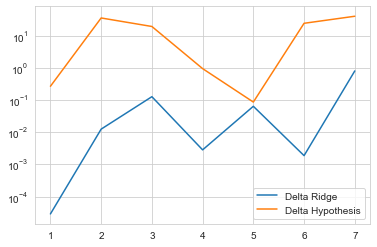

In [283]:
yhats = model(xs, ys)

IDX = 3

SIGMASQ = 0.125
def get_w_hat_ridge(x, y, k, sigmasq=SIGMASQ):
    if k == 1:
        return torch.linalg.inv(x[0].unsqueeze(1) * x[0].unsqueeze(0) + sigmasq * torch.eye(4, device="mps")) @ x[0] * y[0]

    return (torch.linalg.inv(x[:k].T @ x[:k] + sigmasq * torch.eye(4, device="mps")) @ (x[:k].T @ y[:k])).squeeze(-1)

def get_w_hat_hypothesis(x, y, k, sigmasq=SIGMASQ):
    return (k + sigmasq) ** -1 * (x[:k].T @ y[:k]).squeeze(-1)

for IDX in range(5):

    w = ws[IDX]
    x = xs[IDX]
    y = ys[IDX]
    yhat = yhats[IDX]

    print(w.shape, x.shape, y.shape, x[:2].shape)
    w_hat_2_mech = y[0] * x[0] / (x[0].norm() ** 2)
    w_hat_2_ridge = get_w_hat_ridge(x, y, 1)

    x0 = x[0]
    x1 = x[1]

    x0_perp = x0 - x1
    # x0_perp /= x0_perp.norm()
    x0_perp -= x0 @ x0_perp * x0 / x0.norm() ** 2
    x0_perp /= x0_perp.norm()

    x1_perp = x1 - x0
    # x1_perp /= x1_perp.norm()
    x1_perp -= x1 @ x1_perp * x1 / x1.norm() ** 2
    x1_perp /= x1_perp.norm()

    # w_hat_3_mech_0 = w_hat_2_mech - (1 - y[0] ** 2 / x[0].norm() ** 2) * x0_perp
    # w_hat_3_mech_1 = w_hat_2_mech - (1 - y[1] ** 2 / x[1].norm() ** 2) * x1_perp
    # w_hat_3_mech = (w_hat_3_mech_0 + w_hat_3_mech_1) / 2.

    # print(w_hat_3_mech_0, w_hat_3_mech_1, w_hat_3_mech)

    print(x[:1].shape)
    # print(w_hat_2_mech.shape, w_hat_2_ridge.shape)
    print(w_hat_2_mech, w_hat_2_ridge)

    print("\nPrediction")
    print(y[1], yhat[1], w_hat_2_mech @ x[1], w_hat_2_ridge @ x[1])

    print([(get_w_hat_ridge(x, y, k).shape) for k in range(1, 8)])

    w_hats = [get_w_hat_ridge(x, y, k) for k in range(1, 8)]
    yhat_ridge = torch.stack([(w_hats[k-1] @ x[k]) for k in range(1, 8)])

    w_hat_hypotheses = [get_w_hat_hypothesis(x, y, k) for k in range(1, 8)]
    y_hat_hypotheses = torch.stack([(w_hat_hypotheses[k-1] @ x[k]) for k in range(1, 8)])

    # plt.plot(range(1, 8), yhat_ridge.detach().cpu().numpy(), label="Ridge")
    plt.plot(range(1, 8), yhat_ridge.detach().cpu().numpy(), label="Ridge")
    plt.plot(range(0, 8), yhat.detach().cpu().numpy(), label="Pred")
    plt.plot(range(0, 8), y.detach().cpu().numpy(), label="True")
    plt.plot(range(1, 8), y_hat_hypotheses.detach().cpu().numpy(),
     label="Hypothesis")
    # plt.plot(range(1, 3), [(w_hat_2_mech @ x[1]).detach().cpu().numpy(), (w_hat_3_mech @ x[2]).detach().cpu().numpy()], label="Mech")

    plt.legend()

    # print(w_hat_2_mech.norm(), w_hat_3_mech.norm(), [w_hat.norm() for w_hat in w_hats], w.norm())

    plt.show()

    print(yhat_ridge.shape, yhat.shape)

    plt.plot(range(1, 8), (yhat_ridge.detach().cpu().numpy() - yhat[1:].squeeze(-1).detach().cpu().numpy()) ** 2, label="Delta Ridge")
    plt.plot(range(1, 8), (y_hat_hypotheses.detach().cpu().numpy() - yhat[1:].squeeze(-1).detach().cpu().numpy()) ** 2, label="Delta Hypothesis")
    # plt.plot(range(1, 3), [(w_hat_2_mech @ x[1] - yhat[1]).detach().cpu().numpy() ** 2, (w_hat_3_mech @ x[2] - yhat[2]).detach().cpu().numpy() ** 2], label="Delta Mech")
    plt.yscale("log")
    plt.legend()

    plt.show()

    # print((ws.norm(dim=1) ** 2).mean())

    # w_hat_3_mech_proj_onto_x12 = (w_hat_2_mech @ x[:2].T @ x[:2]).detach().cpu().numpy()
    # w_hat_3_ridge_proj_onto_x12 = (w_hats[2] @ x[:2].T @ x[:2]).detach().cpu().numpy()

    # plt.arrow(0, 0, w_hat_3_mech_proj_onto_x12[0], w_hat_3_mech_proj_onto_x12[1], head_width=0.05, head_length=0.05, color='red', label="Manual")
    # plt.arrow(0, 0, w_hat_3_ridge_proj_onto_x12[0], w_hat_3_ridge_proj_onto_x12[1], head_width=0.05, head_length=0.05, color='blue', label="Ridge")

    # mech_proj_distance = np.linalg.norm(w_hat_3_mech_proj_onto_x12 - w_hat_2_mech.detach().cpu().numpy())
    # ridge_proj_distance = np.linalg.norm(w_hat_3_ridge_proj_onto_x12 - w_hats[2].detach().cpu().numpy())

    # plt.legend()
    # print(mech_proj_distance, ridge_proj_distance)
    # plt.show()



In [278]:
embedding_matrices[-1][1]

tensor([ 3.5983,  0.3219,  0.1501,  0.0970, -0.1325])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


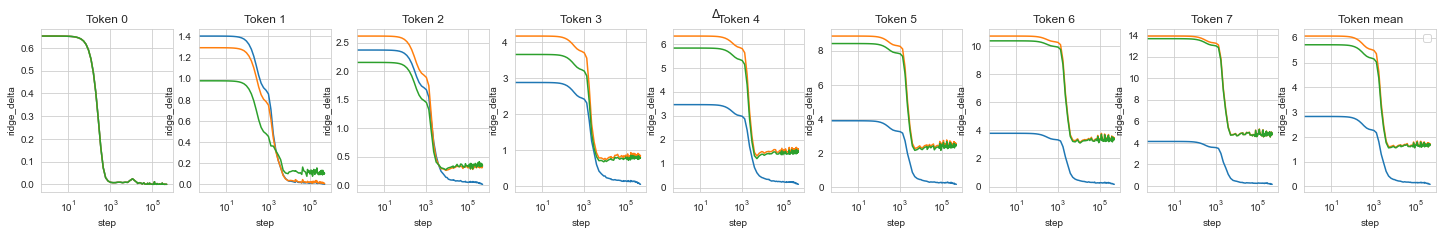

In [338]:
from icl.baselines import ridge_predictor
from torch.nn import functional as F
from fancy_einsum import einsum


def get_yridges(xs, ys, yhats, noise_variance=SIGMASQ, device="mps"):
    yhat, what = ridge_predictor(xs, ys, noise_variance, return_ws_hat=True)

    return what, yhat

def get_yhat0s(xs, ys, yhats, noise_variance=SIGMASQ, device="mps"):
    LHS = torch.empty(B, K, D, D, device=device)
    RHS = torch.empty(B, K, D, 1, device=device)
    
    for k in range(K): # unclear how to (or whether to) vectorise
        Xk  = xs[:, :k, :]                  # B K D         -> B k D
        yk  = ys[:, :k, :]                  # B K 1         -> B k 1
        # compute the normal equations for this k
        XkT = Xk.transpose(-2, -1)          # B k D         -> B D k
        # LHS[:, k, :, :] = k + 1
        Xk_invmags = Xk.norm(dim=-1) ** -2      # B k D         -> B k
        Xk_invs = einsum("B K D, B K -> B K D", Xk, Xk_invmags)
        XkT_invs = Xk_invs.transpose(-2, -1)    # B k D         -> B D k

        # LHS[:, k, :, :] = XkT_invs @ Xk_invs        # B D k @ B k D -> B D D
        LHS[:, k, :, :] = k + 1
        RHS[:, k, :, :] = XkT_invs @ yk         

    LHS = (LHS + noise_variance) ** -1
    # LHS -= (noise_variance ** -1) * torch.eye(D, device=device).unsqueeze(0).unsqueeze(0)

    # whats = einsum('B K D D, B K D C -> B K D C', LHS, RHS)
    whats = RHS / (1 + noise_variance)
    yridgelims = einsum('B K D C, B K D -> B K C', whats, xs)
    
    return whats, yridgelims


def sgd_step(xs, ys, whats, yhats, noise_variance=SIGMASQ, device="mps", lr=0.1):
    gradient = torch.zeros_like(whats)
    yhat0s = einsum('B K D C, B K D -> B K C', whats, xs)

    for k in range(K):
        gradient[:, k, :, :] = einsum("B k C, B k D -> B D C", (ys[:, :k, :] - yhat0s[:, :k, :]), xs[:, :k, :]) / (k + 1)

    what1s = whats - lr * gradient
    yhat1s = einsum('B K D C, B K D -> B K C', what1s, xs)

    return what1s, yhat1s 

def eval_model_behavioral_deltas(model, xs, ys):
    yhats = model(xs, ys)
    wridges, yridges = get_yridges(xs, ys, yhats)
    what0s, yhat0s = get_yhat0s(xs, ys, yhats)
    what1s, yhat1s = sgd_step(xs, ys, what0s, yhat0s, lr=.1)
    
    deltaridges = ((yhats - yridges) ** 2).mean(dim=0)
    delta0s = ((yhats - yhat0s) ** 2).mean(dim=0)
    delta1s = ((yhats - yhat1s) ** 2).mean(dim=0)
    return deltaridges, delta0s, delta1s

df = []

for step, model in zip(steps, models):
    ridge_delta, delta0_solns, delta1_solns = eval_model_behavioral_deltas(model, xs, ys)

    for t in range(8):
        df.append({
            "step": step,
            "ridge_delta": ridge_delta[t].item(),
            "delta0": delta0_solns[t].item(),
            "delta1": delta1_solns[t].item(),
            "token": t
        })

    df.append({
        "step": step,
        "ridge_delta": ridge_delta.mean().item(),
        "delta0": delta0_solns.mean().item(),
        "delta1": delta1_solns.mean().item(),
        "token": "mean"
    })

df = pd.DataFrame(df)

fig, axes = plt.subplots(1, 9, figsize=(25, 3))
plt.suptitle("$\Delta$")

for i, token in enumerate(df.token.unique()):
    ax = axes[i]
    ax.set_title(f"Token {token}")
    sns.lineplot(data=df.loc[df.token==token], x='step', y='ridge_delta', ax=ax)
    sns.lineplot(data=df.loc[df.token==token], x='step', y='delta0', ax=ax)
    sns.lineplot(data=df.loc[df.token==token], x='step', y='delta1', ax=ax)

for ax in axes.flatten():
    ax.set_xscale("log")
    # ax.set_ylim(0, 3.2)
    # ax.set_yscale("log")

axes[-1].legend()